In [217]:
# Конфигурация путей и функции загрузки
from pathlib import Path
import pandas as pd
import time
import numpy as np

data_dir = Path(r'C:\Users\USER\Desktop\hakaton\data')
assert data_dir.is_dir(), f"Не найдена папка с данными: {data_dir}"

def load_csv(name, **kwargs):
    file_path = data_dir / name
    start = time.time()
    df = pd.read_csv(file_path, **kwargs)
    elapsed = time.time() - start
    print(f"{name}: shape={df.shape}, time={elapsed:.3f}s")
    return df

# Анализ данных клиентских сессий сервиса 'СберАвтоподписка'
---
### *В этом ноутбуке мы реализуем три стадии машинного обучения:*

* Business understanding (выстроим понимание бизнесс-процессов сервиса 'СберАвтоподписка' и возможности для его улучшения на основе данных клиентских сессий);
* Data understanding (изучим предоставленные данные и выявим их связь с реальными процессами)
* Data preparation (подготовим данные для проведения обучения моделей)


**Цели и задачи ноутбука**:  

* ознакомление с предоставленными датасетами и описаниями представленных атрибутов;
* оценка чистоты и полноты данных;  
* выстраивание картины понимания что стоит за этими данными в реальном мире;
* приведение данных в удобный вид для дальнейшей работы;
* проведение базовой чистки (дубликаты, пустые значения, типизация данных, ненужные атрибуты;
* анализ ключевых распределений данных и их взаимосвязей;
* подготовка плана по форматированию данных.  
 ---

## 1. Импорт необходимых библиотек и модулей

In [221]:
import time
import os
import sys
import warnings
from pathlib import Path
from typing import Sequence, Union
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from additional_data import (
    social_media_sources, target_events, moscow_region_cities, organic_mediums, 
    russian_holidays, get_distance_from_moscow, big_cities, missing_values)

## 2. Загрузка данных из файлов `ga_hits.csv`, `ga_sessions.csv`

In [223]:
# подготовим абсолютный путь до папки с данными
path = r'C:\Users\USER\Desktop\hakaton\data'

# Проверим, что папка существует
assert os.path.isdir(path), f"Папка не найдена: {path}"

# Считаем файлы
ga_hits     = pd.read_csv(os.path.join(path, 'ga_hits.csv'))
ga_sessions = pd.read_csv(os.path.join(path, 'ga_sessions.csv'))

# Проверка
print(ga_hits.shape, ga_sessions.shape)

(15726470, 11) (1860042, 18)


In [224]:
path = r'C:\Users\USER\Desktop\hakaton\data'
file_ga_hits = os.path.join(path, 'ga_hits.csv')

start = time.time()
df_ga_hits = pd.read_csv(file_ga_hits)
elapsed_time = time.time() - start

print(
    f'Файл ga_hits.csv прочитан, '
    f'размер {df_ga_hits.shape}, '
    f'время чтения {elapsed_time:.3f} сек.'
)

Файл ga_hits.csv прочитан, размер (15726470, 11), время чтения 32.706 сек.


In [225]:
# Полный путь к файлу ga_sessions.csv
file_ga_sessions = os.path.join(path, 'ga_sessions.csv')

start = time.time()  # включим таймер для подсчёта времени чтения
df_session = pd.read_csv(file_ga_sessions, low_memory=False)
elapsed_time = time.time() - start  # зафиксируем время чтения

print(
    f'Датасет сеансов успешно прочитан из файла ga_sessions.csv,\n'
    f'Размеры датасета: {df_session.shape},\n'
    f'Время чтения файла в датасет: {elapsed_time:.3f} сек.'
)

Датасет сеансов успешно прочитан из файла ga_sessions.csv,
Размеры датасета: (1860042, 18),
Время чтения файла в датасет: 5.190 сек.


### Настройка вывода информации (графики, столбцы, предупреждения)


In [227]:
sns.set() # эта функция меняет глобальные переменные: все последующие графики отрисовываются в том же стиле.
plt.rc('figure', figsize=(18, 6)) # устанавливаем размеры графиков по умолчанию
pd.set_option('display.max_columns', 100) # настрим показ максимального количества столбцов
warnings.filterwarnings('ignore') # никогда не печатать соответствующие предупреждения

## 3. Общий анализ датасетов

---
В датасете `ga_hits.csv` содержатся данные о событиях в рамках каждой сессии из другого датасета `ga_sessions.csv`. 

Размеры датасета `ga_hits.csv`: 15 726 470 строк × 11 колонок. В датасетах собраны события в рамках одного визита за период с 2021-05-19 по  2021-12-31. Это данные с начала запуска сервиса 'СберАвтоподписка' до конца 2021 года. 

Дубликатов в обоих датасетах нет. 

Описания, тип и пропуски обоих датосетов по признакам представлены в таблицах ниже:

 `ga_hits.csv`                                                                         

| # | Column          |       Description                        |Dtype      | isna    |
|---|-----------------|------------------------------------------|-----------|---------|
| 0 |   session_id    | ID визита                                |  object   |0        |    
| 1 |   hit_date      | дата события                             |  object   |0        |
| 2 |   hit_time      | время события                            |  float64  |9160322  |
| 3 |   hit_number    | порядковый номер события в рамках сессии |  int64    |0        |
| 4 |   hit_type      | тип события                              |  object   |0        |
| 5 |   hit_referer   | источник события                         |  object   |6274804  |
| 6 |   hit_page_path | страница события                         |  object   |0        |
| 7 |   event_category| тип действия                             |  object   |0        |
| 8 |   event_action  | действие                                 |  object   |0        |
| 9 |   event_label   | тег действия                             |  object   |3760184  |
| 10|   event_value   | значение результата действия              |  float64  |15726470 |

`df_session`

|#    |Column                   | Description                      | Dtype  | isna    |
|-----|-------------------------|----------------------------------|--------|---------|
| 0   |session_id               | ID визита                        |object  |  0      |
| 1   |client_id                | ID посетителя                    |object  |0        |
| 2   |visit_date               | дата визита                      |object  |0        |
| 3   |visit_time               | время визита                     | object |0        |
| 4   |visit_number             | порядковый номер визита клиента  |int64   |0        |
| 5   |utm_source               | канал привлечения                |object  |97       |
| 6   |utm_medium               | тип привлечения                  |object  |0        |
| 7   |utm_campaign             | рекламная кампания               | object |219603   |
| 8   |utm_adcontent            |                                  |object  |335615   |
| 9   |utm_keyword              | ключевое слово                   | object |1082061  |
| 10  |device_category          | тип устройства                   |object  |0        |
| 11  |device_os                | ОС устройства                    |  object|1070138  |
| 12  |device_brand             | марка устройства                 |  object|367178   |
| 13  |device_model             | модель устройства                | object |1843704  |
| 14  |device_screen_resolution | разрешение экрана                | object |0        |
| 15  |device_browser           | браузер                          | object |0        |
| 16  |geo_country              | страна                           |object  |0        |
| 17  |geo_city                 | город                            | object |0        |







In [230]:
df_ga_hits

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15726465,6866159858916559617.1640270865.1640270865,2021-12-23,810589.0,43,event,NaN,sberauto.com/cars/all/toyota/fortuner/24cb5af2...,quiz,quiz_show,NaN,NaN
15726466,7310304587364460692.1640261783.1640261783,2021-12-23,904927.0,40,event,NaN,sberauto.com/cars/all/mercedes-benz/gla-klasse...,quiz,quiz_show,NaN,NaN
15726467,8013702685784312179.1640270195.1640270195,2021-12-23,2172865.0,43,event,NaN,sberauto.com/cars/all/toyota/alphard/2ebe4871?...,quiz,quiz_show,NaN,NaN
15726468,8021505554734405918.1640257821.1640257821,2021-12-23,713325.0,45,event,NaN,sberauto.com/cars/all/bmw/x3/6a660f0a?rental_p...,quiz,quiz_show,NaN,NaN


In [231]:
df_session

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk


In [232]:
print(f'В датасете df_ga_hits собраны события в рамках одного визита за период с {df_ga_hits.hit_date.min()} по  {df_ga_hits.hit_date.max()}') # Период предоставленных данных
print(f'В датасете df_sessions собраны события в рамках одного визита за период с {df_session.visit_date.min()} по  {df_session.visit_date.max()}')

В датасете df_ga_hits собраны события в рамках одного визита за период с 2021-05-19 по  2021-12-31
В датасете df_sessions собраны события в рамках одного визита за период с 2021-05-19 по  2021-12-31


In [233]:

df_ga_hits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [234]:
df_ga_hits.isna().sum()

session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value       15726470
dtype: int64

In [235]:
print(f'Количество дубликатов в df_ga_hits: {df_ga_hits.duplicated().sum()}') 

Количество дубликатов в df_ga_hits: 0


In [236]:
print(f'Количество дубликатов в df_session: {df_session.duplicated().sum()}') 

Количество дубликатов в df_session: 0


## 4. Анализ датасета `df_ga_hits` 

---
Целевые действия находятся в `event_action`. Всего уникальных событий - 230. Больше всего нецелевых событий. Продукт новый, высокостоимостной, пользователи активно его изучают. Они активно кликают по галерее с предложениями. Так `view_card`, `view_new_card`, `sub_landing`, `go_to_car_card`, `sub_view_cars_click` стоят в топе событий c заметным отрывом.  Однако, реально полезных  целевых действий всего 104908 из 15 726 470 что составляет менее одного процента (0.67 %).

Максимальное число событий в сессию - 768, которая имело место 2021-09-24. Такое большое количество встречается очень редко. В-основном, чаще всего встечаются от 1 до 50 событий в сессию.

Интересно, что всплеск событий за одну сессию приходится на даты с 2021-09-22 по 2021-09-24.

Целевые события в общем числе событий распределены следующим образом:

sub_car_claim_click = 37928 === 0.24 %

sub_open_dialog_click = 25870 === 0.16 %

sub_submit_success = 18439 === 0.12 %

sub_car_claim_submit_click = 12359 === 0.08 %

sub_call_number_click = 3653 === 0.02 %

sub_callback_submit_click = 3074 === 0.02 %

sub_car_request_submit_click = 2966 === 0.02 %

sub_custom_question_submit_click = 619 === 0.0 %









In [239]:
# выведем значения и их количество из столбца event_action (ДЕЙСТВИЕ)
df_ga_hits.event_action.value_counts().head(10)

event_action
view_card                  3558985
view_new_card              3551009
sub_landing                1798117
go_to_car_card              973666
sub_view_cars_click         791515
search_form_region          512069
search_form_search_btn      433748
sap_search_form_cost_to     356596
showed_number_ads           326274
pagination_click            248944
Name: count, dtype: int64

In [240]:
# Выведем сколько всего уникальных значений в event_action
df_ga_hits.event_action.nunique()
   

230


Целевое действие — события типа «Оставить заявку» и «Заказать звонок»  
    
    
(ga_hits.event_action in
    
['sub_car_claim_click',
    
'sub_car_claim_submit_click',
    
'sub_open_dialog_click', 
    
'sub_custom_question_submit_click',
    
'sub_call_number_click', 
    
'sub_callback_submit_click', 
    
'sub_submit_success',
    
'sub_car_request_submit_click']). 





В датасете df_ga_hits хранятся действия пользователей

████████████████████████████████████████████████████████████████

Всего целевых действий = 104908 из 15726470 что составляет  0.67 %

sub_car_claim_click = 37928 === 0.24 %
sub_open_dialog_click = 25870 === 0.16 %
sub_submit_success = 18439 === 0.12 %
sub_car_claim_submit_click = 12359 === 0.08 %
sub_call_number_click = 3653 === 0.02 %
sub_callback_submit_click = 3074 === 0.02 %
sub_car_request_submit_click = 2966 === 0.02 %
sub_custom_question_submit_click = 619 === 0.0 %


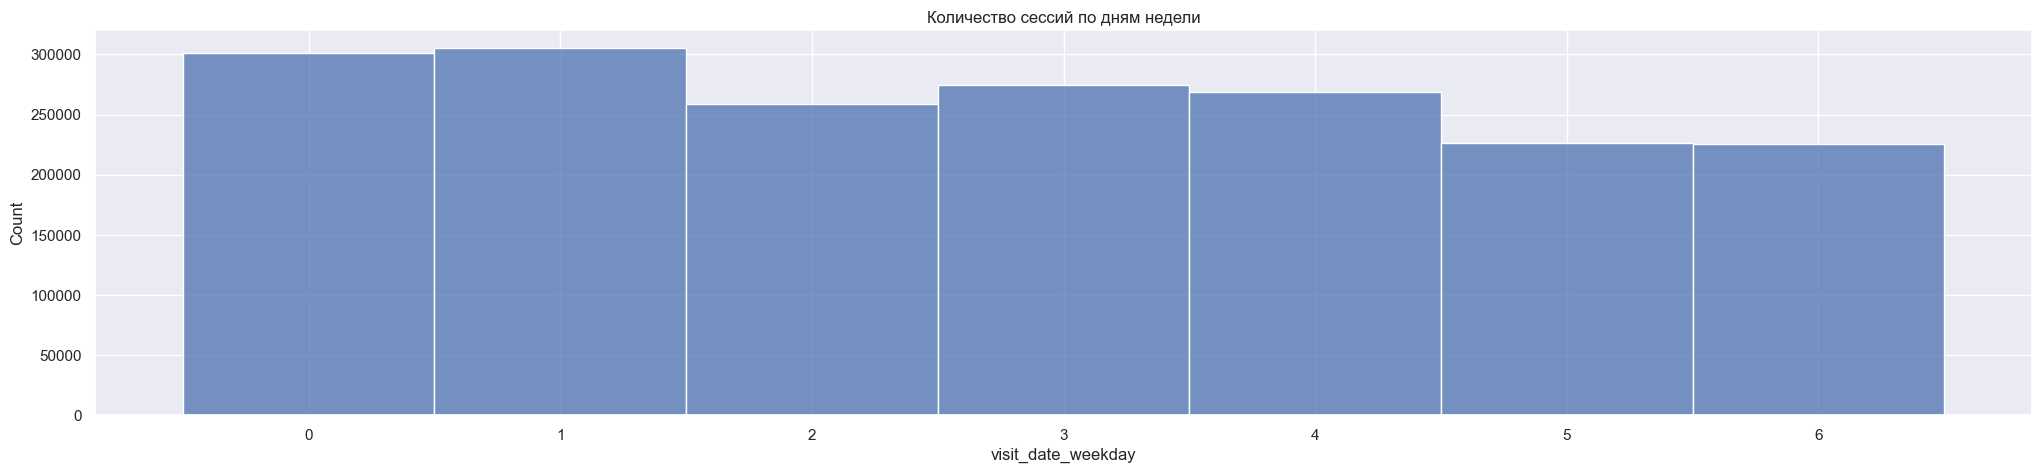

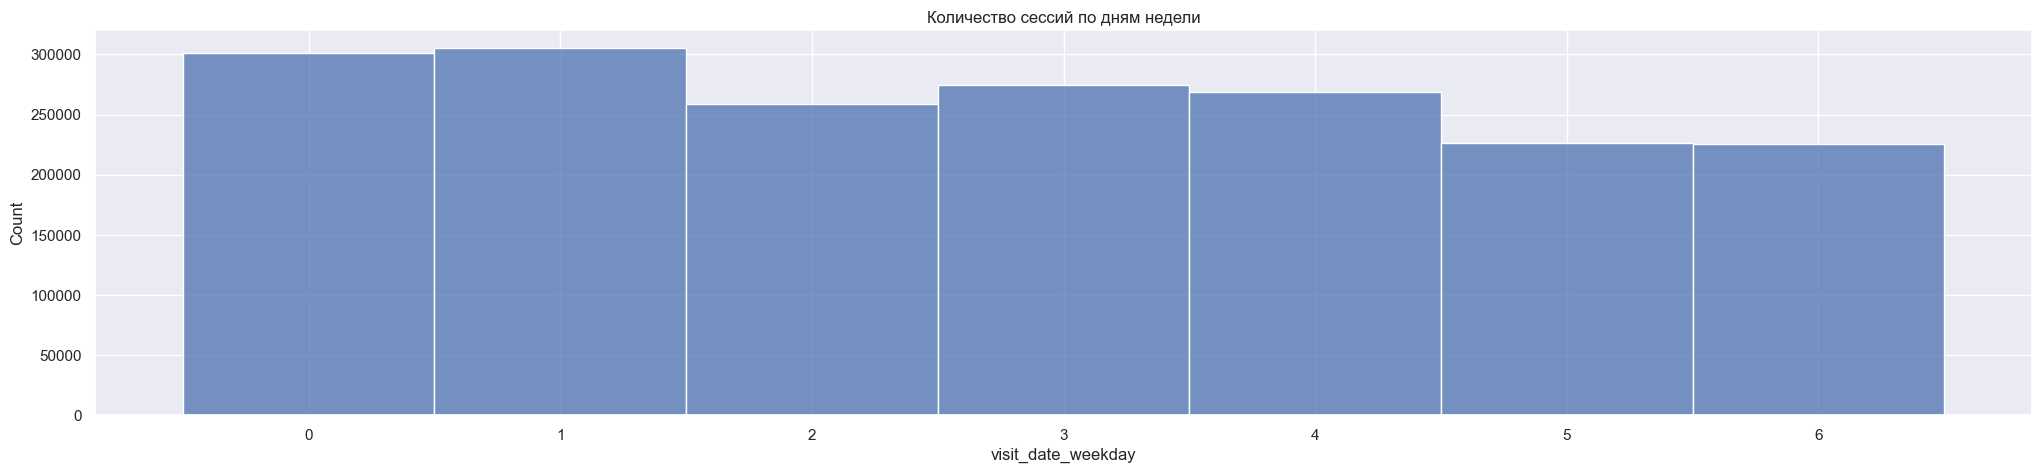

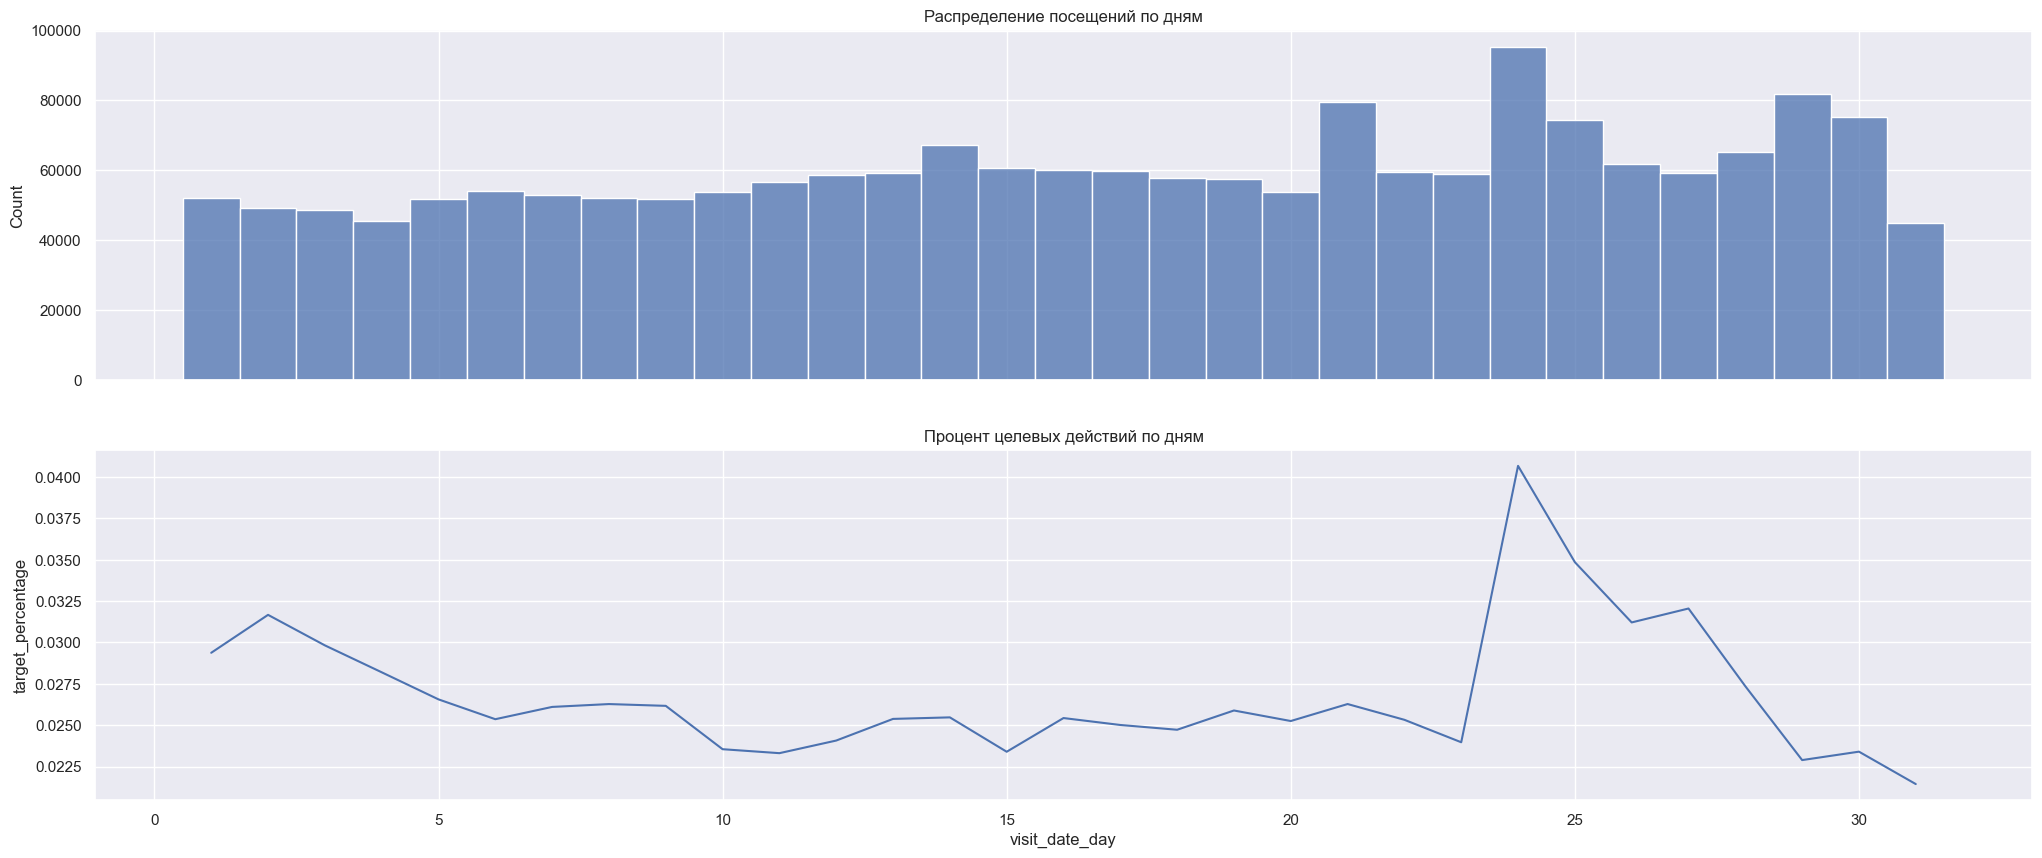

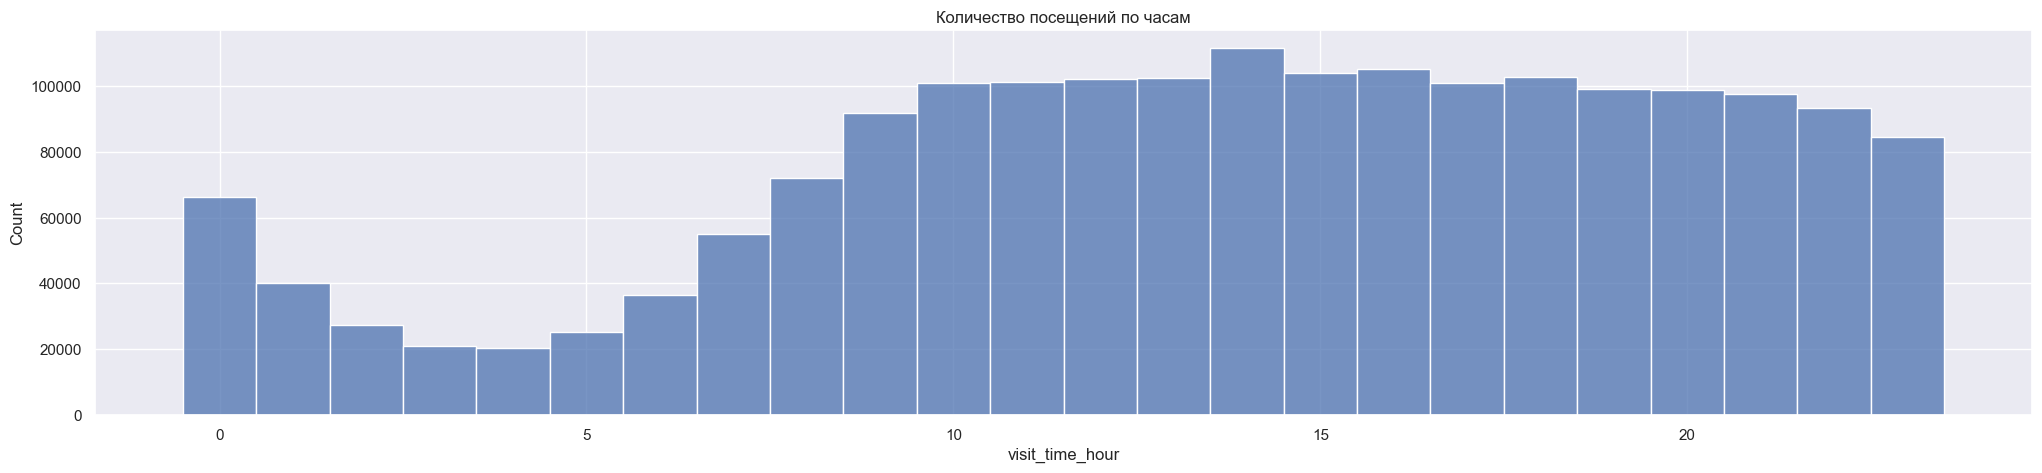

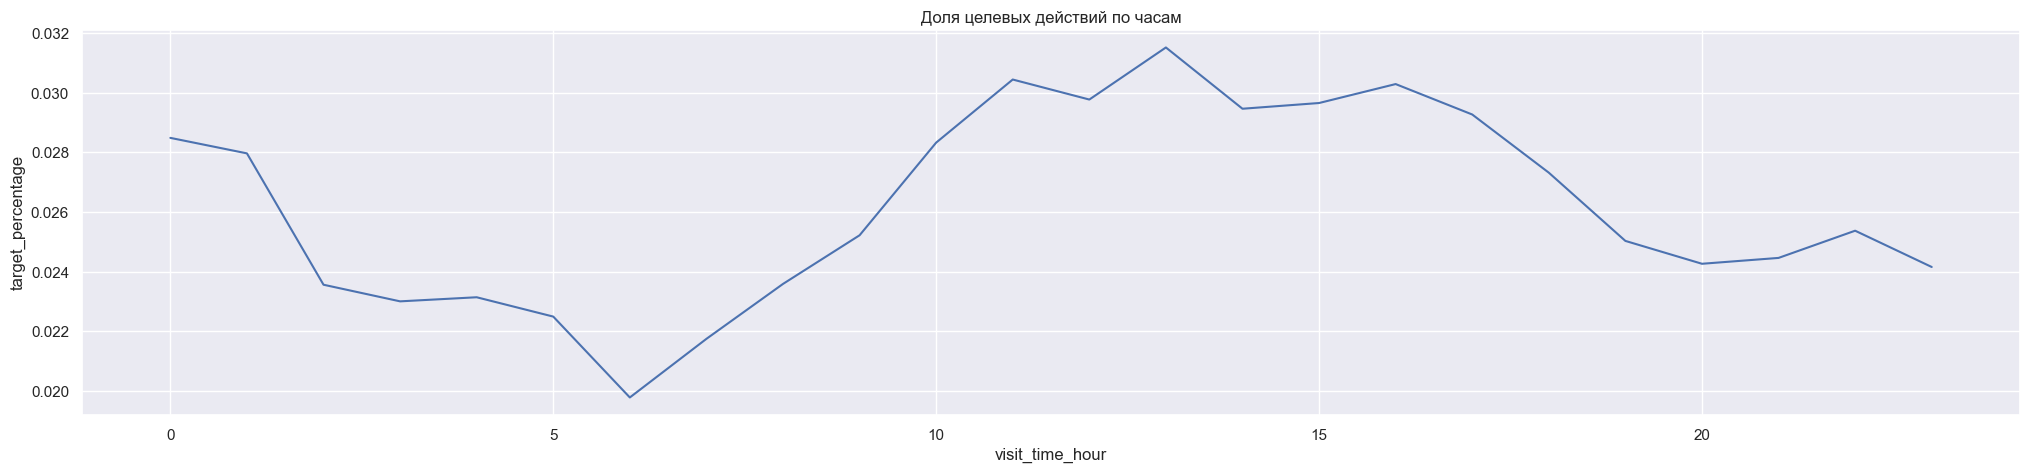

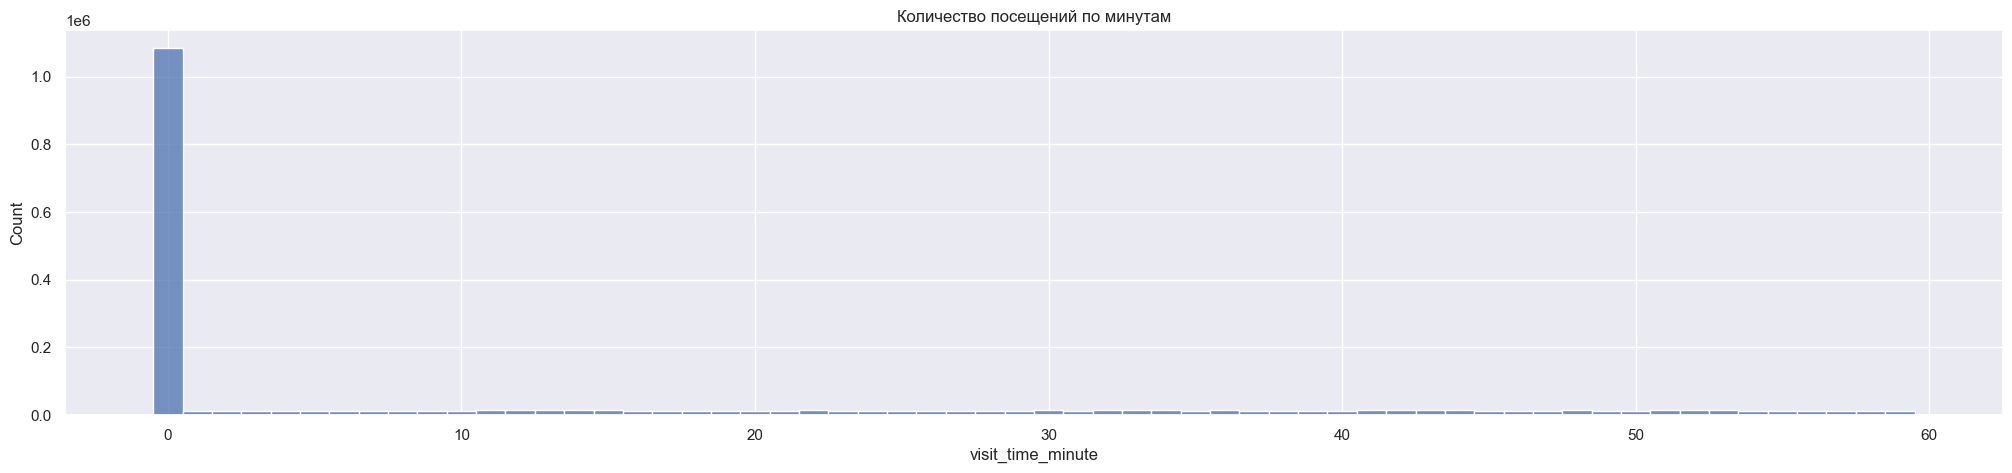

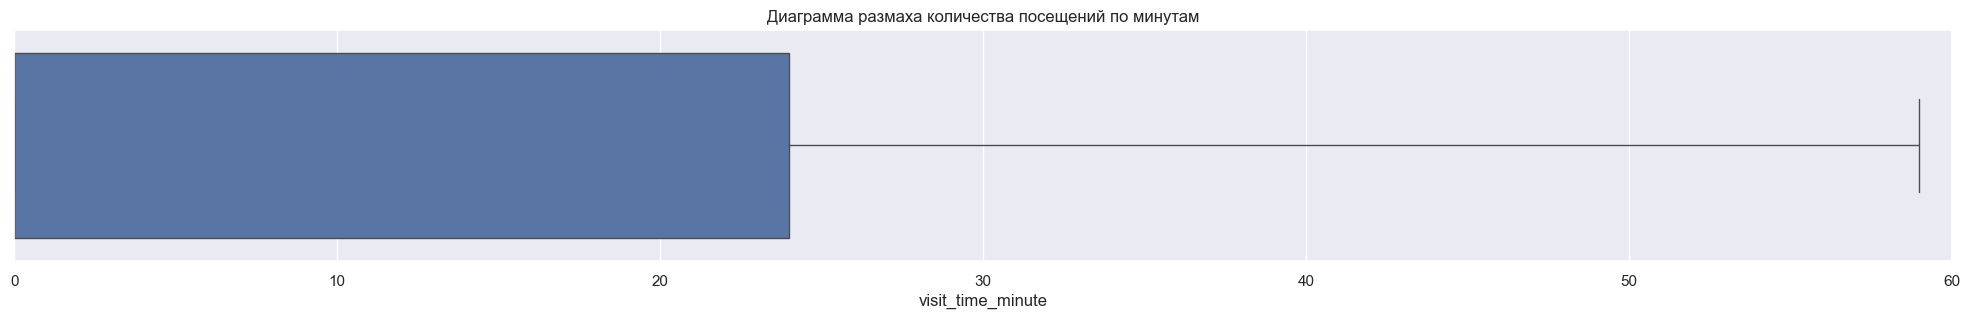

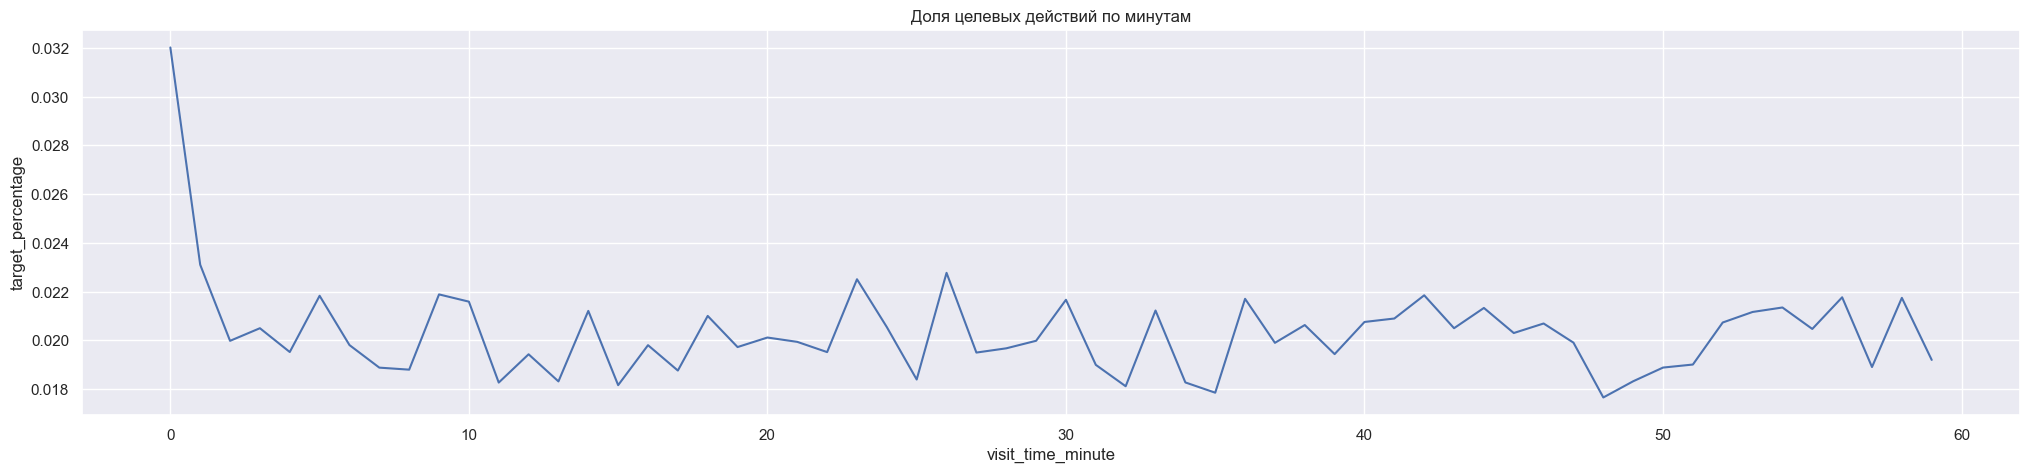

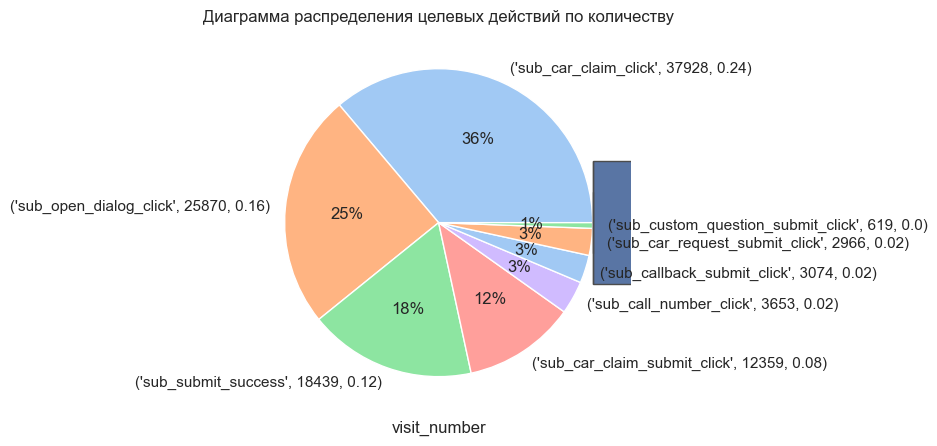

In [243]:
# Выведем, сколько всего целевых действий и их долю в общем количестве действий
all_targets = ['sub_car_claim_click',

'sub_car_claim_submit_click',

'sub_open_dialog_click',

'sub_custom_question_submit_click',

'sub_call_number_click',

'sub_callback_submit_click',

'sub_submit_success',

'sub_car_request_submit_click']

sorted_all_targets = []
total = 0
i = 0
labels, data = [], []

for targets_name in all_targets:
    
    value = len(df_ga_hits[df_ga_hits['event_action'] == targets_name])
    percent = round(value/len(df_ga_hits)*100, 2)
    sorted_all_targets.append((targets_name, value, percent))
    
    total += value
    
    i += 1
    print("████████", end='')
    #print(targets_name, '=', value, f"=== {percent}%")
#print("█", end='')
sorted_all_targets = sorted(sorted_all_targets, key=lambda sorted_all_targets: sorted_all_targets[1],  reverse=True)
print(f'\n\nВсего целевых действий = {total} из {len(df_ga_hits)} что составляет {total/len(df_ga_hits)*100: .2f} %\n')
for target in sorted_all_targets:
    data.append(target[1])
    labels.append(target)
    print(target[0], '=', target[1], '===', target[2], '%')   

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

#create pie chart

#plt.figure(figsize=(8, 8))
plt.title("Диаграмма распределения целевых действий по количеству")
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()


In [244]:
event_counts = df_ga_hits['session_id'].value_counts() # выведем количество событий в одну сессию
#event_counts.name = 'event_counts'
event_counts.head(5)

session_id
5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
Name: count, dtype: int64

In [245]:
#n_by_state = df.groupby("state")["last_name"].count() .sort_values(by='likes', ascending=False) utm_campaign

dates_max_events = df_ga_hits.groupby(['session_id', 'hit_date']).count()

In [246]:
dates_max_events.sort_values(by='event_action', ascending=False)

,,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
session_id,hit_date,,,,,,,,,
5442565791571325612.1632449195.1632449195,2021-09-24,384,768,768,384,768,768,768,430,0
6568868914238486437.1632270313.1632270313,2021-09-22,339,678,678,339,678,678,678,439,0
5959671972744778783.1632490527.1632490600,2021-09-24,274,548,548,274,548,548,548,320,0
7452598043578978502.1632358598.1632358598,2021-09-23,257,514,514,257,514,514,514,257,0
3070792010704358528.1629752408.1629752408,2021-08-24,0,498,498,498,498,498,498,498,0
...,...,...,...,...,...,...,...,...,...,...
7332600372471986108.1628931928.1628931928,2021-08-14,0,1,1,1,1,1,1,1,0
7332600372471986108.1628929805.1628929805,2021-08-14,0,1,1,1,1,1,1,1,0
7332600372471986108.1628926536.1628926536,2021-08-14,0,1,1,1,1,1,1,1,0


In [247]:
# выведем частоту событий в одну сессию
d = pd.DataFrame(event_counts.value_counts())



In [248]:
d

,count
count,
1,537243
2,237658
6,88086
3,85233
4,63603
...,...
304,1
302,1
296,1


In [249]:
d.index.name = None
d.reset_index(inplace=True)
d.rename(columns={'index':'events_per_session'}, inplace=True)
print(d.head())

   events_per_session   count
0                   1  537243
1                   2  237658
2                   6   88086
3                   3   85233
4                   4   63603


In [250]:
numeric_df = df_ga_hits.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
print(corr_matrix)

             hit_time  hit_number  event_value
hit_time     1.000000    0.605906          NaN
hit_number   0.605906    1.000000          NaN
event_value       NaN         NaN          NaN


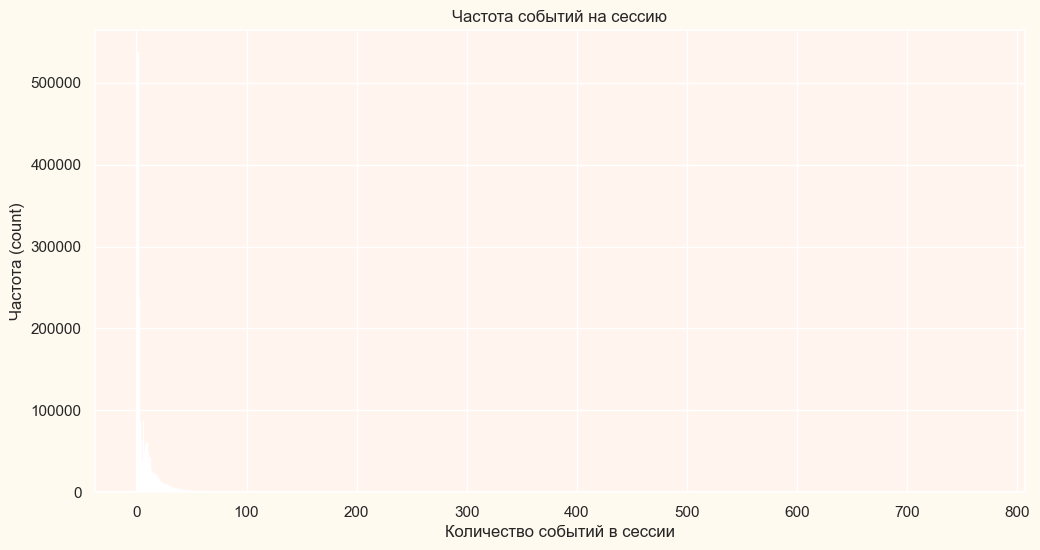

In [251]:
x = d['events_per_session']
y = d['count']

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, y)
ax.set_xlabel('Количество событий в сессии')
ax.set_ylabel('Частота (count)')
ax.set_title('Частота событий на сессию')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
plt.show()

## 5. Дополнение датасета `df_session` целевыми переменными в столбец `target` 

В датасете df_session хранятся сессии пользователей.

Введем новый столбец `target`, где запишем целевые события, которые возьмем из `event_action`. Целевую переменную считаем положительной, если за сессию состоялось хотя бы одно из целевых событий. Для тех сессий в `sessions`, для которых не нашлось ни одного события в `df_ga_hits`, целевую переменную заполняем значением `0`.

Только 2.7% всех сессий закончилось совершением целевого действия.

In [254]:
df_ga_hits['target'] = df_ga_hits['event_action'].isin(all_targets) # заполняет столбец df_ga_hits['target'] 'True', если df_ga_hits['event_action'] содержит целевую
target = df_ga_hits.groupby('session_id')['target'].any() # target группирует по id (session_id) и по столбцу 'target', то есть все одинаковые session_id собираются
df_session = df_session.join(target, on='session_id') # добавляем к df_session target

In [255]:
df_session.head()


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,False
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,False
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,False
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,False
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,False


In [256]:
def as_percent(x: float) -> str:
    """Используется для преобразования доли в процент (в виде строки)."""
    
    return f'{x:0.2%}'

print('Распределение целевой переменной:')
df_session["target"].value_counts(dropna=False, normalize=True).apply(as_percent)


Распределение целевой переменной:


target
False    90.43%
NaN       6.87%
True      2.70%
Name: proportion, dtype: object

In [257]:
df_session['target'] = df_session['target'].fillna(False).astype(int) # заполним Nan как False и все переведем в '0' и '1' 


In [258]:
df_session["target"].value_counts(dropna=False, normalize=True).apply(as_percent)

target
0    97.30%
1     2.70%
Name: proportion, dtype: object

In [259]:
target.value_counts()

target
False    1683850
True       50760
Name: count, dtype: int64

In [260]:
df_ga_hits['target'].value_counts()

target
False    15621562
True       104908
Name: count, dtype: int64

## 6. Анализ датасета `df_session` 

После добавления столбца `target` датфрейм имеет размеры: 1 860 042 строки и 19 столбцов. 

### `session_id` - ID визита  

Пустых значений в колонке нет. Все значения в колонке уникальны.  
Данная колонка может использоваться в качестве индекса в окончательном датасете.

In [263]:
all_unique = df_session['session_id'].nunique()
print(f'Все значения колонки `session_id` уникальны: {all_unique}')

Все значения колонки `session_id` уникальны: 1860042


### `client_id` - ID посетителя  

Пустых значений в колонке нет. А уникальных значений слишком много, 74,82%

Вряд ли получится вытащить полезную информацию из этой колонки. Она просто не будет использоваться.  


In [265]:
print(f'Количество уникальных значений в `client_id`: '
      f'{df_session["client_id"].nunique()/len(df_session)*100:.2f}% от общего количества.')

Количество уникальных значений в `client_id`: 74.82% от общего количества.


### `visit_date` - дата визита  

Пустых значений в колонке нет.  

Диапазон представленных дат: с 19 мая 2021 по 31 декабря 2021.  За изучаемый период 226 дней сайт посетили и совершили 50760 целевых действий.


В целом на графике количества посещений наблюдается небольшой восходящий тренд.  

И ещё на графике очень заметен пик посещений в мае 2021, скорее всего это связано с запуском сервиса и проведенной в связи с этим рекламной кампанией, новостями о новом сервисе.  

Больше сессий происходит и больше целевых действий совершается в начале недели.

Сама колонка `visit_date` участвовать в окончательном датасете не будет, но из неё можно получить признаки `visit_date_weekday` - день недели, `visit_date_weekend` - выходной ли, `visit_date_day` - день месяца, `visit_date_holiday` - является ли день праздничным в России.

In [267]:
df_session['visit_date'] = pd.to_datetime(df_session['visit_date']) # переведем данные столбца в формат даты

In [268]:
n_unique = df_session['visit_date'].nunique()
print(f'Количество уникальных значений в `visit_date`: {n_unique}')

Количество уникальных значений в `visit_date`: 226


In [269]:
df_session['visit_date'].describe()

count                          1860042
mean     2021-09-26 11:45:55.389394176
min                2021-05-19 00:00:00
25%                2021-08-02 00:00:00
50%                2021-10-06 00:00:00
75%                2021-11-23 00:00:00
max                2021-12-31 00:00:00
Name: visit_date, dtype: object

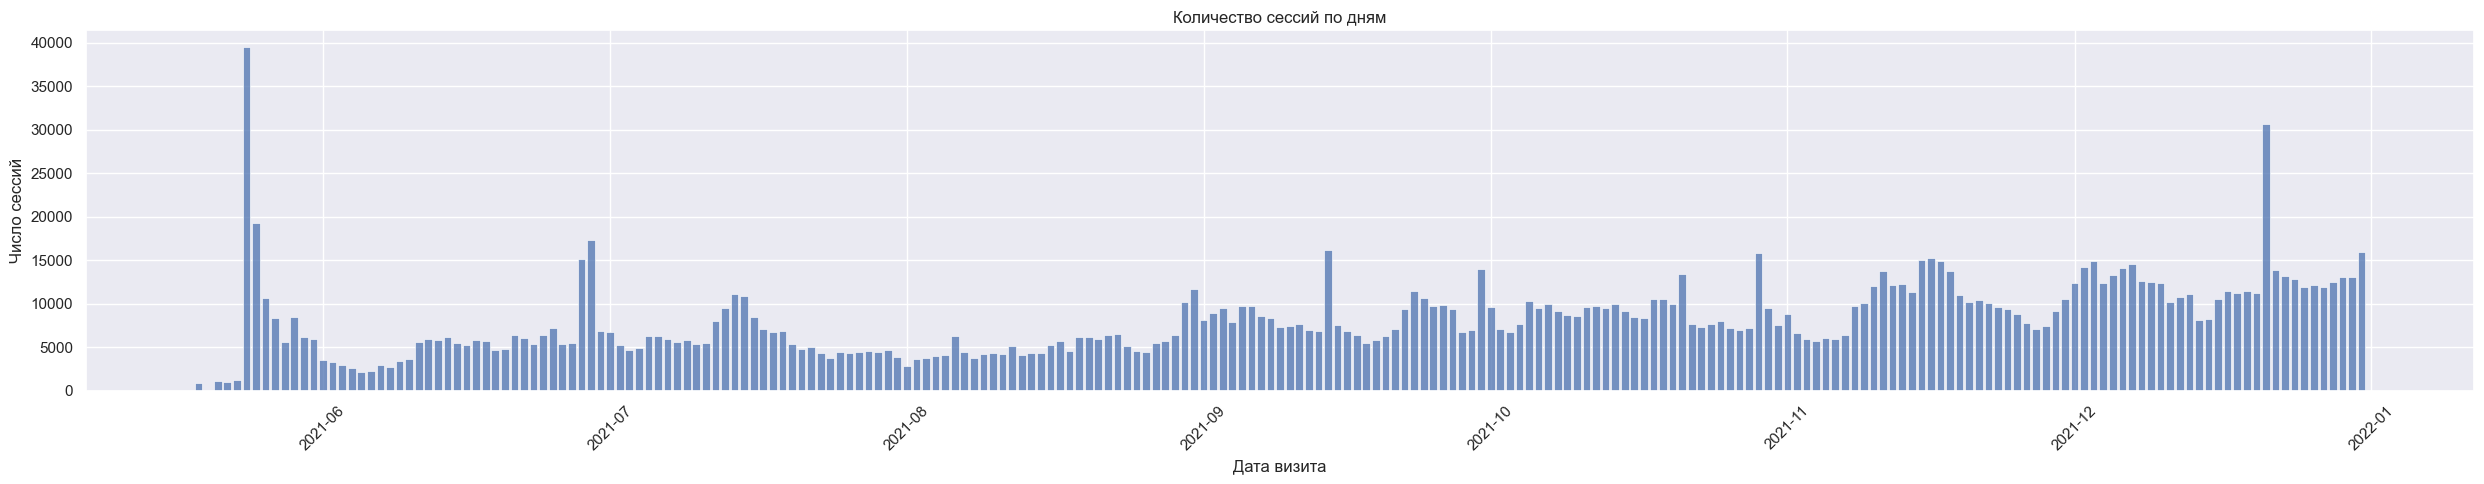

In [270]:
df_session['visit_date'] = pd.to_datetime(df_session['visit_date'])

# Построение гистограммы
plt.figure(figsize=(25, 5))
sns.histplot(
    data=df_session,
    x='visit_date',
    discrete=True,      # по дискретным «дням»
    stat='count',
    shrink=0.8         
)
plt.title('Количество сессий по дням')
plt.xlabel('Дата визита')
plt.ylabel('Число сессий')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

### Для того, чтобы проанализировать количество посещений по дням, создадим  новый признак - день недели `visit_date_weekday`.

In [272]:
df_session['visit_date_weekday'] = df_session['visit_date'].dt.day_of_week

In [273]:
plt.figure(figsize=(25, 5))
sns.histplot(data=df_session, x='visit_date_weekday', discrete=True)
plt.title('Количество сессий по дням недели');

In [274]:
# Функция определения процента целевых действий
def target_percentage(
    data: pd.DataFrame, 
    column: str, 
    index_name: str = '',
    only_target: bool = False, 
    sort: bool = True, 
    percent: bool = True 
) -> Union[pd.DataFrame, pd.Series]:
    """Возвращает в удобном виде процент целевых действий (`target`==1) 
    по значениям заданной колонки `column`."""

    # названия колонок
    count = 'Количество объектов'
    ratio = 'Доля от общего числа'
    target = 'Процент целевых действий'

    # разбиение по значениям
    groupby = data.groupby(column)
    
    # расчёт количества объектов и доли целевых действий
    result = pd.DataFrame(index=groupby.groups)
    result[count] = groupby[column].count()
    result[ratio] = result[count] / len(data)
    result[target] = groupby['target'].sum() / result[count]
    
    # форматирование выходной таблицы
    result.index.name = index_name or column
    if sort: result = result.sort_values(target, ascending=False)
    if percent: 
        result[target] = result[target].apply(as_percent)
        result[ratio] = result[ratio].apply(as_percent)
    
    # возвращение результатов
    if only_target: 
        return result[target].rename('target_percentage')
    return result

In [275]:
print('Процент целевых действий по дням недели:')
target_percentage(df_session, 'visit_date_weekday', index_name='День недели')

Процент целевых действий по дням недели:


,Количество объектов,Доля от общего числа,Процент целевых действий
День недели,,,
0,300906,16.18%,3.15%
1,305130,16.40%,2.84%
2,258616,13.90%,2.81%
3,274462,14.76%,2.63%
5,226397,12.17%,2.46%
6,225712,12.13%,2.45%
4,268819,14.45%,2.44%


### Для того чтобы пранализировать количество посещений по выходным создадим новый признак, говорящий о выходном дне `visit_date_weekend`.

In [277]:
df_session['visit_date_weekend'] = df_session['visit_date_weekday'] > 4 # присвоим "True" выходным (суббота и воскресенье) 5, 6 > 4

In [278]:
print('Распределение выходных дней:')
target_percentage(df_session, 'visit_date_weekend', index_name='Выходной')

Распределение выходных дней:


,Количество объектов,Доля от общего числа,Процент целевых действий
Выходной,,,
False,1407933,75.69%,2.78%
True,452109,24.31%,2.46%


### Для того, чтобы проанализировать посещения по дням в месяце создадим новый признак - день месяца `visit_date_day`.

In [280]:
df_session['visit_date_day'] = df_session['visit_date'].dt.day # заполняет столбец днем месяца из даты

In [281]:
_, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(25, 10))

ax1.set_title('Распределение посещений по дням')
sns.histplot(data=df_session, x='visit_date_day', discrete=True, ax=ax1)

target_by_day = target_percentage(df_session, 'visit_date_day', 
                                  percent=False, only_target=True)
ax2.set_title('Процент целевых действий по дням')
sns.lineplot(data=target_by_day, ax=ax2);

### Рассмотрим влияние праздников на количество посещений и создадим этот признак `visit_date_holiday`.

In [283]:
df_session['visit_date_holiday'] = df_session['visit_date'].isin(russian_holidays)

In [284]:
print('Распределение праздничных дней:')
target_percentage(df_session, 'visit_date_holiday', index_name='Праздник')

Распределение праздничных дней:


,Количество объектов,Доля от общего числа,Процент целевых действий
Праздник,,,
False,1820148,97.86%,2.71%
True,39894,2.14%,2.54%


### `visit_time` - время визита  

Пустых значений в колонке нет. 

Временные значения представлены от 00:00:00 до 23:59:59, то есть покрывают весь день.  
Пик посещений сайта наблюдается в 14:00, то есть в середине дня.  
Упадок количества посещений - в середине ночи, в 04:00.  

Больший процент сессий закрывается целевым действием в середине дня (11:00-16:00), а меньший - ночью (2:00-6:00).  
Большинство сессий происходит на нулевой минуте каждого часа, причём с большим процентом целевых действий. Это больше похоже на алгоритмические действия, чем на реальные посещения сайта пользователем.

Сам по себе признак `visit_time` неудобен в использовании, но из него можно получить полезные признаки, например, `visit_hour` - час визита пользователя, `visit_minute` - минута визита, `visit_time_night` - была ли ночь во время визита пользователя.

In [286]:
df_session['visit_time'] = pd.to_datetime(df_session['visit_time'])

In [287]:
df_session['visit_time'] = pd.to_datetime(df_session['visit_time'], format='%H:%M:%S')
print(df_session['visit_time'].describe())

seconds = (df_session['visit_time'].dt.hour * 3600 +
           df_session['visit_time'].dt.minute * 60 +
           df_session['visit_time'].dt.second)

print(seconds.describe())

count                          1860042
mean     2025-05-06 13:49:53.502091008
min                2025-05-06 00:00:00
25%                2025-05-06 10:00:00
50%                2025-05-06 14:09:06
75%                2025-05-06 19:00:00
max                2025-05-06 23:59:59
Name: visit_time, dtype: object
count    1.860042e+06
mean     4.979350e+04
std      2.208650e+04
min      0.000000e+00
25%      3.600000e+04
50%      5.094600e+04
75%      6.840000e+04
max      8.639900e+04
Name: visit_time, dtype: float64


### Создадим новый признак - количество посещений по часам `visit_time_hour`.

In [289]:
df_session['visit_time_hour'] = df_session['visit_time'].dt.hour

In [290]:
plt.figure(figsize=(25, 5))
sns.histplot(data=df_session, x='visit_time_hour', discrete=True)
plt.title('Количество посещений по часам');

In [291]:
plt.figure(figsize=(25, 5))
target_by_hour = target_percentage(df_session, 'visit_time_hour', 
                                   percent=False, only_target=True)
sns.lineplot(data=target_by_hour)
plt.title('Доля целевых действий по часам');

### Создадим новый признак - посещения по минутам `visit_time_minute`.

In [293]:
df_session['visit_time_minute'] = df_session['visit_time'].dt.minute

In [294]:
plt.figure(figsize=(25, 5))
sns.histplot(data=df_session, x='visit_time_minute', discrete=True)
plt.title('Количество посещений по минутам');

In [295]:
plt.figure(figsize=(25
                    , 3))
plt.title('Диаграмма размаха количества посещений по минутам')
plt.xlim(0, 60)
sns.boxplot(x=df_session['visit_time_minute']);

In [296]:
plt.figure(figsize=(25, 5))
target_by_minute = target_percentage(df_session, 'visit_time_minute', 
                                     percent=False, only_target=True)
sns.lineplot(data=target_by_minute)
plt.title('Доля целевых действий по минутам');

In [297]:
df_session['visit_time_minute_is_zero'] = df_session['visit_time_minute'] == 0
target_percentage(df_session, 'visit_time_minute_is_zero', index_name='0 минут')

,Количество объектов,Доля от общего числа,Процент целевых действий
0 минут,,,
True,1083333,58.24%,3.20%
False,776709,41.76%,2.01%


### Проанализируем посещения в дневное и ночное время, создадим новый признак, говорящий о наступлении ночи - `visit_time_night`.

In [299]:
df_session['visit_time_night'] = df_session['visit_time_hour'] < 9

In [300]:
print('Распределение целевых действий ночью и днём:')
target_percentage(df_session, 'visit_time_night', index_name='Ночное время')

Распределение целевых действий ночью и днём:


,Количество объектов,Доля от общего числа,Процент целевых действий
Ночное время,,,
False,1496535,80.46%,2.77%
True,363507,19.54%,2.42%


### Проанализируем `visit_number` - порядковый номер визита посетителя  

В колонке нет пустых значений. Для каждого посетителя по его `client_id` все его посещения фиксируются в `visit_number`

Большинство, а именно, 74% всех посещений составляет всего одно посещение, после которого клиент больше не заходит на сайт. Дальше на втором месте стоят клиенты, которые посетили сайт всего 2 раза, что составляет почти 13% от всего количества посещений.

Номер посещения колеблется от 1 до 564 посещений сайта. Большинство пользователей ограничиваются одним-двумя посещениями. Можно было бы подумать, что все посещения больше - 4 это выбросы, но, оказывается, что, несмотря, что 74% составляют 1-е посещение и 12.67% составляют 2-е посещения, доля целевых действий в этих параметрах составляют всего 2.35% и 3.23% соответственно. Начиная с 4-го посещения доля целевых посещений в этом сегменте уже составляет свыше 4%.


Похоже, что чем чаще пользователь заходит на сайт, тем выше вероятность, что он совершит целевое действие.  
Вероятно, первый раз пользователи заходят на сайт, чтобы познакомиться с предложением, а если их оно заинтересует, то они вернутся ещё раз.




In [302]:
df_session['visit_number'].describe().apply(lambda x: f'{x:0.1f}')

count    1860042.0
mean           2.7
std           11.8
min            1.0
25%            1.0
50%            1.0
75%            2.0
max          564.0
Name: visit_number, dtype: object

In [303]:
plt.figure(figsize=(25, 5))
sns.boxplot(data=df_session, x='visit_number')
plt.xlim(0, 10)
plt.title('Диаграмма размаха номера посещения');

In [304]:
# приведём все выбросы к значению 4
df_session['visit_number_no_outliers'] = df_session['visit_number'].apply(lambda x: x if x < 4 else 4)

In [305]:
print('Процент успешных сессий в зависимости от номера посещения: ')
target_percentage(df_session, 'visit_number_no_outliers', 
                  index_name='Номер посещения')

Процент успешных сессий в зависимости от номера посещения: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Номер посещения,,,
4,166969,8.98%,4.37%
3,81068,4.36%,3.76%
2,235656,12.67%,3.23%
1,1376349,74.00%,2.35%


In [306]:
# приведём все выбросы к значению 4
df_session['visit_number_no_outliers'] = df_session['visit_number'].apply(lambda x: x if x < 50 else 50)

In [307]:
print('Процент успешных сессий в зависимости от номера посещения: ')
target_percentage(df_session, 'visit_number_no_outliers', 
                  index_name='Номер посещения')

Процент успешных сессий в зависимости от номера посещения: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Номер посещения,,,
6,16473,0.89%,4.85%
10,5413,0.29%,4.75%
11,4473,0.24%,4.69%
9,6692,0.36%,4.69%
7,11640,0.63%,4.55%
8,8735,0.47%,4.52%
50,12668,0.68%,4.44%
5,24271,1.30%,4.43%
18,1606,0.09%,4.42%


### `utm_source` - канал привлечения  

Пропусков в колонке не много - 97.  

Уникальных значений много (293) и вряд ли они несут много полезной информации, можно в окончательный датасет взять только самые частые значения.  

15% трафика из социальных сетей. Но процент целевых действий для него в два раза ниже, чем для остального трафика.

Для популярных каналов привлечения процент целевых действий меняется от 1.21% до 5.43%.

In [309]:
print(f'Пропущенных значений в "utm_source": {df_session.utm_source.isna().sum()}')

Пропущенных значений в "utm_source": 97


In [310]:
n_unique = df_session.utm_source.nunique()
print(f'Количество уникальных значений в `utm_source`: {n_unique}')

Количество уникальных значений в `utm_source`: 293


In [311]:
df_session.utm_source.value_counts(dropna=False).head(20)

utm_source
ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
vFcAhRxLfOWKhvxjELkx     24413
PlbkrSYoHuZBWfYjYnfw     20792
hTjLvqNxGggkGnxSCaTm     14598
gDBGzjFKYabGgSPZvrDH     13565
fgymSoTvjKPEgaIJqsiH      9625
geDcueAOghDzHkGMmdOq      8680
ISrKoXQCxqqYvAZICvjs      8633
nSReTmyFtbSjlPrTKoaX      7285
SzZERoLMmrEUEhDaYcyN      6828
eLzNJHzPelJpEyBwMrKo      5386
Name: count, dtype: int64

In [312]:
# Процент целевых действий для частых значений канала привлечения

def replace_rare(data: pd.Series, tolerance: float = 0.05) -> pd.Series:
    """Заменяет в колонке редкие значения на 'rare_other'. Редкими считаются 
    значения, доля появления которых не превышает `tolerance`. Также заполняет 
    пропуски значением '(nan)'.
    """

    data = data.copy()

    value_counts = data.value_counts(dropna=False)
    rare_values = value_counts[value_counts < (len(data) * tolerance)]
    rare_values = rare_values.index.tolist()
    
    data[data.isin(rare_values)] = 'rare_other'
    return data.fillna('(nan)')

print('Процент целевых действий для частых значений канала привлечения:')
df_session['utm_source_frequent'] = replace_rare(df_session.utm_source) # заполним пропуски и редкие значения 'rare_other' 
target_percentage(df_session, 'utm_source_frequent', 
                  index_name='Канал привлечения')

Процент целевых действий для частых значений канала привлечения:


,Количество объектов,Доля от общего числа,Процент целевых действий
Канал привлечения,,,
bByPQxmDaMXgpHeypKSM,102287,5.50%,5.43%
fDLlAcSmythWSCVMvqvL,300575,16.16%,3.50%
BHcvLfOaCWvWTykYqHVe,116320,6.25%,3.34%
ZpYIoDJMcFzVoPFsHGJL,578290,31.09%,2.77%
kjsLglQLzykiRbcDiGcD,266354,14.32%,2.36%
rare_other,310017,16.67%,1.87%
MvfHsxITijuriZxsqZqt,186199,10.01%,1.21%


Создадим новый признак, говорящий о том, что пользователь перешёл на сайт из социальных сетей - `utm_source_is_social`.

In [314]:
df_session['utm_source_is_social'] =  df_session['utm_source'].isin(social_media_sources) # Заполним 'True', если зашел из социальных сетей

In [315]:
df_session['utm_source_is_social']

0          False
1           True
2          False
3          False
4          False
           ...  
1860037    False
1860038    False
1860039    False
1860040    False
1860041    False
Name: utm_source_is_social, Length: 1860042, dtype: bool

In [316]:
print('Процент целевых действий для пользователей из соцсетей и остальных:')
target_percentage(df_session, 'utm_source_is_social', index_name='Из соцсетей')

Процент целевых действий для пользователей из соцсетей и остальных:


,Количество объектов,Доля от общего числа,Процент целевых действий
Из соцсетей,,,
False,1585815,85.26%,2.92%
True,274227,14.74%,1.47%


### `utm_medium` - тип привлечения  

Пустых значений в колонке `utm_medium` 301 055 - значения (none) и  (not set). Уникальных значений немного - 56.  

Множество значений появляется в датасете слишком малое количество раз. 

Органический трафик составляет 28%. И для него процент целевых действий значительно выше, чем для остальных типов привлечения.  
Самые популярные типы трафика: banner, cpc, cpm, refferal, organic.  

Для самых частых значений `utm_medium` процент целевых действий меняется от 1.04% до 5.38%.

In [318]:
# Возвращает, что пучтых значений нет.....
print(f'Количество пустых значений в `utm_medium`: {df_session.utm_medium.isna().sum()}')

Количество пустых значений в `utm_medium`: 0


In [319]:
# ...но при выводе количества уникальных значений, замечаем, что есть (none) и (not set), что также является пропусками!
df_session.utm_medium.value_counts(dropna=False).head(30)

utm_medium
banner             552272
cpc                434794
(none)             300575
cpm                242083
referral           152050
organic             63034
email               29240
push                28035
stories             10582
cpv                  8022
blogger_channel      8015
smartbanner          6794
blogger_stories      4312
cpa                  4279
tg                   4011
app                  2836
post                 2326
smm                  1985
outlook              1332
clicks                934
blogger_header        771
(not set)             480
info_text             343
sms                   239
landing               134
partner                97
fb_smm                 66
vk_smm                 65
link                   57
cbaafe                 47
Name: count, dtype: int64

In [320]:
def count_missings(data: pd.Series) -> int:
    """Возвращает количество пропущенных значений в pd.Series."""

    return data.isin(missing_values).sum() # missing_values - сохраним что будем считать пропусками


In [321]:
missings = count_missings(df_session.utm_medium)
print(f'Количество пустых значений в `utm_medium`: {missings}')

Количество пустых значений в `utm_medium`: 301055


In [322]:
n_unique = df_session.utm_medium.nunique()
print(f'Количество уникальных значений в `utm_medium`: {n_unique}')

Количество уникальных значений в `utm_medium`: 56


In [323]:
print('Процент целевых действий для частых значений типа привлечения:')
df_session['utm_medium_frequent'] = replace_rare(df_session['utm_medium'])
target_percentage(df_session, 'utm_medium_frequent', index_name='Тип привлечения')

Процент целевых действий для частых значений типа привлечения:


,Количество объектов,Доля от общего числа,Процент целевых действий
Тип привлечения,,,
referral,152050,8.17%,5.38%
(none),300575,16.16%,3.50%
banner,552272,29.69%,2.74%
rare_other,178268,9.58%,2.49%
cpc,434794,23.38%,2.19%
cpm,242083,13.01%,1.04%


Построим новый признак, отвечающий за органический трафик - `utm_medium_is_organic`.

In [325]:
df_session['utm_medium_is_organic'] = df_session['utm_medium'].isin(organic_mediums)

In [326]:
df_session.target

0          0
1          0
2          0
3          0
4          0
          ..
1860037    0
1860038    0
1860039    0
1860040    0
1860041    0
Name: target, Length: 1860042, dtype: int32

In [327]:
df_session.groupby('utm_medium_is_organic').nunique() 

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target,visit_date_weekday,visit_date_weekend,visit_date_day,visit_date_holiday,visit_time_hour,visit_time_minute,visit_time_minute_is_zero,visit_time_night,visit_number_no_outliers,utm_source_frequent,utm_source_is_social,utm_medium_frequent
utm_medium_is_organic,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1344383,1068094,226,84820,514,80,53,401,219,1155,3,13,191,101,4230,49,151,1935,2,7,2,31,2,24,60,2,2,50,6,2,4
True,515659,350609,226,62598,360,219,3,219,188,279,3,12,127,66,2305,39,152,1812,2,7,2,31,2,24,60,2,2,50,5,2,3


In [328]:
print('Распределение органического трафика:')
target_percentage(df_session, 'utm_medium_is_organic', 
                  index_name='Органический трафик')

Распределение органического трафика:


,Количество объектов,Доля от общего числа,Процент целевых действий
Органический трафик,,,
True,515659,27.72%,4.04%
False,1344383,72.28%,2.19%


### `utm_campaign` - рекламная кампания  

12% значений в колонке пропущено.  
Уникальных значений в колонке 412, причём большая часть уникальных значений встречается в датасете очень редко. 

Для самых частых значений процент целевых действий меняется от 0.99% до 4.10%.

In [330]:
print(f'Количество пустых значений в `utm_campaign`: {df_session.utm_campaign.isna().sum()}')

Количество пустых значений в `utm_campaign`: 219603


In [331]:
missings = count_missings(df_session['utm_campaign']) / len(df_session)
print(f'Количество пропущенных значений в `utm_campaign`: {count_missings(df_session.utm_campaign)}, что составляет {missings:0.2%}')

Количество пропущенных значений в `utm_campaign`: 219603, что составляет 11.81%


In [332]:
n_unique = df_session['utm_campaign'].nunique()
print(f'Количество уникальных значений в `utm_campaign` = {n_unique}')

Количество уникальных значений в `utm_campaign` = 412


In [333]:
df_session['utm_campaign'].value_counts(dropna=False).head(15)

utm_campaign
LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24511
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
LwJZxKuWmvOhPsaCeRjG     17615
RoDitORHdzGfGhNCyEMy     15706
bxOTvPtyGSdUrbwoXCPO     15415
zxoiLxhuSIFrCeTLQVWZ     12370
bJJuEXRheRIxXEaYIXqM     12232
Name: count, dtype: int64

In [334]:
print('Процент целевых действий для самых частых значений рекламной кампании:')
df_session['utm_campaign_frequent'] = replace_rare(df_session['utm_campaign'], 0.05)
target_percentage(df_session, 'utm_campaign_frequent', 
                  index_name='Рекламная кампания')

Процент целевых действий для самых частых значений рекламной кампании:


,Количество объектов,Доля от общего числа,Процент целевых действий
Рекламная кампания,,,
LTuZkdKfxRGVceoWkVyg,463481,24.92%,4.10%
gecBYcKZCPMcVYdSSzKP,134042,7.21%,3.39%
(nan),219603,11.81%,3.27%
LEoPHuyFvzoNfnzGgfcd,324044,17.42%,2.88%
rare_other,471512,25.35%,1.65%
FTjNLDyTrXaWYgZymFkV,247360,13.30%,0.99%


### `utm_adcontent`  

18% значений в колонке пропущено.  
В колонке 286 уникальных значений, но большая их часть слишком редко встречается в данных.  

Для популярных значений процент целевых действий меняется от 1.08% до 3.37%.

In [336]:
missings = count_missings(df_session['utm_adcontent']) / len(df_session)
print(f'Количество пропущенных значений в `utm_adcontent`: {missings:0.2%}')

Количество пропущенных значений в `utm_adcontent`: 18.04%


In [337]:
n_unique = df_session['utm_adcontent'].nunique()
print(f'Количество уникальных значений в `utm_adcontent` = {n_unique}')

Количество уникальных значений в `utm_adcontent` = 286


In [338]:
df_session['utm_adcontent'].value_counts(dropna=False).head(15)

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006599
NaN                      335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24222
TuyPWsGQruPMpKvRxeBF      18189
UxrnyMlRBSOhOjytXnMG      13583
dUuXlWzvmhDSyclWRhNP      10280
yYdBRbPmBMUZHXwqGxNx       9700
WYLajZgbUhGimwBKDZUH       8610
SOkCdPxfUcZUzzOdgGES       7319
AdeErYgVTbRcAWtHrMHq       6391
nNqUcgFgcqQbTVSvgaHr       6192
aYAcKhelKzYpXrRYknSP       5090
Name: count, dtype: int64

In [339]:
print('Процент целевых действий для частых значений utm_adcontent:')
df_session['utm_adcontent_frequent'] = replace_rare(df_session['utm_adcontent'])
target_percentage(df_session, 'utm_adcontent_frequent')

Процент целевых действий для частых значений utm_adcontent:


,Количество объектов,Доля от общего числа,Процент целевых действий
utm_adcontent_frequent,,,
JNHcPlZPxEMWDnRiyoBf,1006599,54.12%,3.37%
(nan),335615,18.04%,2.61%
vCIpmpaGBnIQhyYNkXqp,181048,9.73%,2.16%
xhoenQgDQsgfEPYNPwKO,113072,6.08%,1.12%
rare_other,223708,12.03%,1.08%


### `utm_keyword` - ключевое слово  

Пропущенных значений в колонке очень много - 58%. И уникальных значений в колонке - 1219, что говорит о малой ценности этой колонки. Скорее всего из этой колонки будет взято только самое популярное значение puhZPIYqKXeFPaUviSjo.  

Больший процент целевых действий у объектов с пропущенными значениями keyword.

In [341]:
missings = count_missings(df_session['utm_keyword']) / len(df_session)
print(f'Количество пропущенных значений в `utm_keyword`: {missings:0.2%}')

Количество пропущенных значений в `utm_keyword`: 58.17%


In [342]:
n_unique = df_session['utm_keyword'].nunique()
print(f'Количество уникальных значений в `utm_keyword` = {n_unique}')

Количество уникальных значений в `utm_keyword` = 1219


In [343]:
df_session['utm_keyword'].value_counts(dropna=False).head(15)

utm_keyword
NaN                     1082061
puhZPIYqKXeFPaUviSjo     506819
aXQzDWsJuGXeBXexNHjc      24241
pHqgLcdBQPSLcrTpLkdr      13767
ITfrGJNwVsHBGJMAKoct      13353
hAmNSZmQkKQKAjZEGlgb      11297
UKNBOHebRIIsQRsjNKay      10946
IGUCNvHlhfHpROGclCit       7568
RkpOyeEPgcMBSDuHLQcj       6978
JajANoFxoqXfKRNBUhzx       6758
BmOOOIoWGHEfxEfoUezs       6602
ZNhSIPchlbnKwZWcsKzz       5661
pucKZkLDtpMDBTobJAJG       5391
RrhnkuoaqckNtJpAZDzH       5004
YQXPpoLsxnykCWKhGEmI       4874
Name: count, dtype: int64

In [344]:
print('Процент целевых действий для частых значений utm_keyword:')
df_session['utm_keyword_frequent'] = replace_rare(df_session['utm_keyword'], 0.01)
target_percentage(df_session, 'utm_keyword_frequent')

Процент целевых действий для частых значений utm_keyword:


,Количество объектов,Доля от общего числа,Процент целевых действий
utm_keyword_frequent,,,
(nan),1082061,58.17%,3.20%
puhZPIYqKXeFPaUviSjo,506819,27.25%,2.21%
rare_other,246921,13.28%,1.81%
aXQzDWsJuGXeBXexNHjc,24241,1.30%,0.30%


### `device_category` - тип устройства  

Пропущенных значений в колонке нет.  
Уникальных значений немного, а значит проблем с использованием колонки не возникнет.  

С компьютера пользователи совершили больше (в процентах) целевых действий, чем с мобильных устройств.  


In [346]:
missings = count_missings(df_session['device_category'])
print(f'Количество пропущенных значений в `device_category`: {missings}')

Количество пропущенных значений в `device_category`: 0


In [347]:
n_unique = df_session['device_category'].nunique()
print(f'Количество уникальных значений в `device_category` = {n_unique}')

Количество уникальных значений в `device_category` = 3


In [348]:
df_session['device_category'].value_counts(dropna=False)

device_category
mobile     1474871
desktop     366863
tablet       18308
Name: count, dtype: int64

In [349]:
print('Процент целевых действий по категориям устройств: ')
target_percentage(df_session, 'device_category', index_name='Тип устройства')

Процент целевых действий по категориям устройств: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Тип устройства,,,
desktop,366863,19.72%,3.14%
mobile,1474871,79.29%,2.60%
tablet,18308,0.98%,2.31%


### `device_os` - ОС устройства  

Пропущенных значений в колонке 58%. Уникальных значений - 13, но большинство встречается слишком редко.  

Больший процент целевых действий был совершен с устройств с неизвестной ОС и с Macintosh. 

In [351]:
device_os = df_session['device_os']

In [352]:
missings = count_missings(df_session['device_os']) / len(df_session)
print(f'Количество пропущенных значений в `device_os`: {missings:0.2%}')

Количество пропущенных значений в `device_os`: 57.55%


In [353]:
n_unique = df_session['device_os'].nunique()
print(f'Количество уникальных значений в `device_os` = {n_unique}')

Количество уникальных значений в `device_os` = 13


In [354]:
device_os.value_counts(dropna=False)

device_os
NaN              1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: count, dtype: int64

In [355]:
print('Процент целевых действий для популярных ОС: ')
df_session['device_os_frequent'] = replace_rare(df_session['device_os'], 0.01)
target_percentage(df_session, 'device_os_frequent', index_name='ОС')

Процент целевых действий для популярных ОС: 


,Количество объектов,Доля от общего числа,Процент целевых действий
ОС,,,
(nan),1070138,57.53%,3.22%
Macintosh,24824,1.33%,3.11%
Android,464054,24.95%,2.04%
iOS,207104,11.13%,1.89%
Windows,88307,4.75%,1.85%
rare_other,5615,0.30%,1.60%


### `device_brand` - марка устройства  

Количество пропущенных значений в колонке около 20%. Уникальных значений 205.  

Процент целевых действий для популярных марок меняется в небольшом промежутке от 2.29% до 3.14%. Причём больший процент с устройств неизвестной марки.

In [357]:
missings = count_missings(df_session['device_brand']) / len(df_session)
print(f'Количество пропущенных значений в `device_brand`: {missings:0.2%}')

Количество пропущенных значений в `device_brand`: 20.68%


In [358]:
n_unique = df_session['device_brand'].nunique()
print(f'Количество уникальных значений в `device_brand` = {n_unique}')

Количество уникальных значений в `device_brand` = 205


In [359]:
df_session['device_brand'].value_counts(dropna=False).head(15)

device_brand
Apple        551088
NaN          367178
Samsung      332194
Xiaomi       288367
Huawei       185853
Realme        19058
(not set)     17545
OPPO          13504
Vivo          11740
OnePlus        9965
Asus           7929
Nokia          7285
Sony           6459
ZTE            6365
Google         5150
Name: count, dtype: int64

In [360]:
print('Процент целевых действий для частых значений марки устройства:')
df_session['device_brand_frequent'] = replace_rare(df_session['device_brand'])
target_percentage(df_session, 'device_brand_frequent', 
                  index_name='Марка устройства')

Процент целевых действий для частых значений марки устройства:


,Количество объектов,Доля от общего числа,Процент целевых действий
Марка устройства,,,
(nan),367178,19.74%,3.14%
Samsung,332194,17.86%,3.03%
Apple,551088,29.63%,2.63%
Huawei,185853,9.99%,2.43%
rare_other,135362,7.28%,2.34%
Xiaomi,288367,15.50%,2.29%


### `device_model` - модель устройства  

Пропущенных значений в колонке - 99%, а значит использоваться она не будет.  


In [362]:
missings = count_missings(df_session['device_model']) / len(df_session)
print(f'Количество пропущенных значений в `device_model`: {missings:0.2%}')

Количество пропущенных значений в `device_model`: 99.12%


In [363]:
n_unique = df_session['device_model'].nunique()
print(f'Количество уникальных значений в `device_model` = {n_unique}')

Количество уникальных значений в `device_model` = 104


In [364]:
df_session['device_model'].value_counts(dropna=False).head(15)

device_model
NaN                     1843704
AuMdmADEIoPXiWpTsBEj       9778
tWBQlsvNfHxRUjaPAfhd        653
cwMJxNXiWUgMUxGiCTPs        651
pTgAEPipQxDXCjPrJbHo        461
FJApgTrMAGHoxCxQVKws        372
tfPZFRbtlzEssBEesRwM        335
pcvPxfVFaAmhwFmvIeYd        325
aCLaTVQlHcXbUnQYQvIg        236
mzJXHtJPIOSHoHtgezIA        235
JAIKWwxRffFOXQcfGTVi        198
zFCiMWkbbAhTflrlLWnz        176
jXFxTkHxuiBKWOvUtsIa        170
mSVMBvlHFgftJaQAZEdp        152
AshpvdJdReafUzEMmWGr        141
Name: count, dtype: int64

In [365]:
print('Распределение пропущенного и остальных значений device_model:')
df_session['device_model_frequent'] = replace_rare(df_session['device_model'], 0.01)
target_percentage(df_session, 'device_model_frequent')

Распределение пропущенного и остальных значений device_model:


,Количество объектов,Доля от общего числа,Процент целевых действий
device_model_frequent,,,
(nan),1843704,99.12%,2.71%
rare_other,16338,0.88%,2.09%


### `device_screen_resolution` - разрешение экрана  

Пропущенных значений в колонке всего 19 (значения '0x0', '(not set)'). Самое часто встречающееся значение - 414x896  встречается- 169090 раз. Пропуски заменим на самое частое значение в колонке. Уникальных значений очень много - 5039.  

Напрямую использовать признак не получится, но можно из него получить новые признаки, такие как: соотношение сторон, площадь, ширина и высота экрана.  

Но в таких производных признаках много выбросов, которые нужно будет обработать.  

Целевая переменная не коррелирует ни с одним производным признаком. Судя по диаграммам размаха те, пользователи, у которых разрешение экрана выше, более склонны совершить целевое действие.  

In [367]:
df_session['device_screen_resolution'].isna().sum()

0

In [368]:
missings = count_missings(df_session['device_screen_resolution'])
print(f'Пропущенных значений в `device_screen_resolution`:', missings)

Пропущенных значений в `device_screen_resolution`: 19


In [369]:
df_session['device_screen_resolution'].value_counts().head(10)

device_screen_resolution
414x896      169090
1920x1080    125768
375x812      117944
393x851      115454
375x667       93341
360x780       92182
360x800       80547
412x915       74744
360x640       70588
390x844       60827
Name: count, dtype: int64

In [370]:
missed_mask = df_session['device_screen_resolution'].isin(missing_values)
df_session[missed_mask]['device_screen_resolution'].value_counts(dropna=False)

device_screen_resolution
0x0          11
(not set)     8
Name: count, dtype: int64

In [371]:
n_unique = df_session['device_screen_resolution'].nunique()
print(f'Уникальных значений в `device_screen_resolution` = {n_unique}')

Уникальных значений в `device_screen_resolution` = 5039


In [372]:
df_session['device_screen_resolution'].value_counts(dropna=False).head()

device_screen_resolution
414x896      169090
1920x1080    125768
375x812      117944
393x851      115454
375x667       93341
Name: count, dtype: int64

Разобъём колонку на ширину и высоту - `device_screen_width` и `device_screen_height`.

In [374]:
# создаем split, кторый будест состоять из ширины и длины. Перед этим пропущенные значения заменим на '414x896' и разделим в "х" и сохраним как целочисленное значение
split = df_session['device_screen_resolution'].replace(missing_values, '414x896').str.split('x', expand=True).astype(int)
# создадим столбцы с шириной и длиной, куда занесем значения
df_session[['device_screen_width', 'device_screen_height']] = split


In [375]:
df_session[['device_screen_width', 'device_screen_height']].describe()

,device_screen_width,device_screen_height
count,1.860042e+06,1.860042e+06
mean,6.567073e+02,8.408794e+02
std,5.531421e+02,1.939526e+02
min,1.800000e+02,2.560000e+02
25%,3.600000e+02,7.600000e+02
50%,3.930000e+02,8.440000e+02
75%,4.280000e+02,8.960000e+02
max,5.924000e+03,2.000000e+04


In [376]:
df_session.device_screen_width.describe()

count    1.860042e+06
mean     6.567073e+02
std      5.531421e+02
min      1.800000e+02
25%      3.600000e+02
50%      3.930000e+02
75%      4.280000e+02
max      5.924000e+03
Name: device_screen_width, dtype: float64

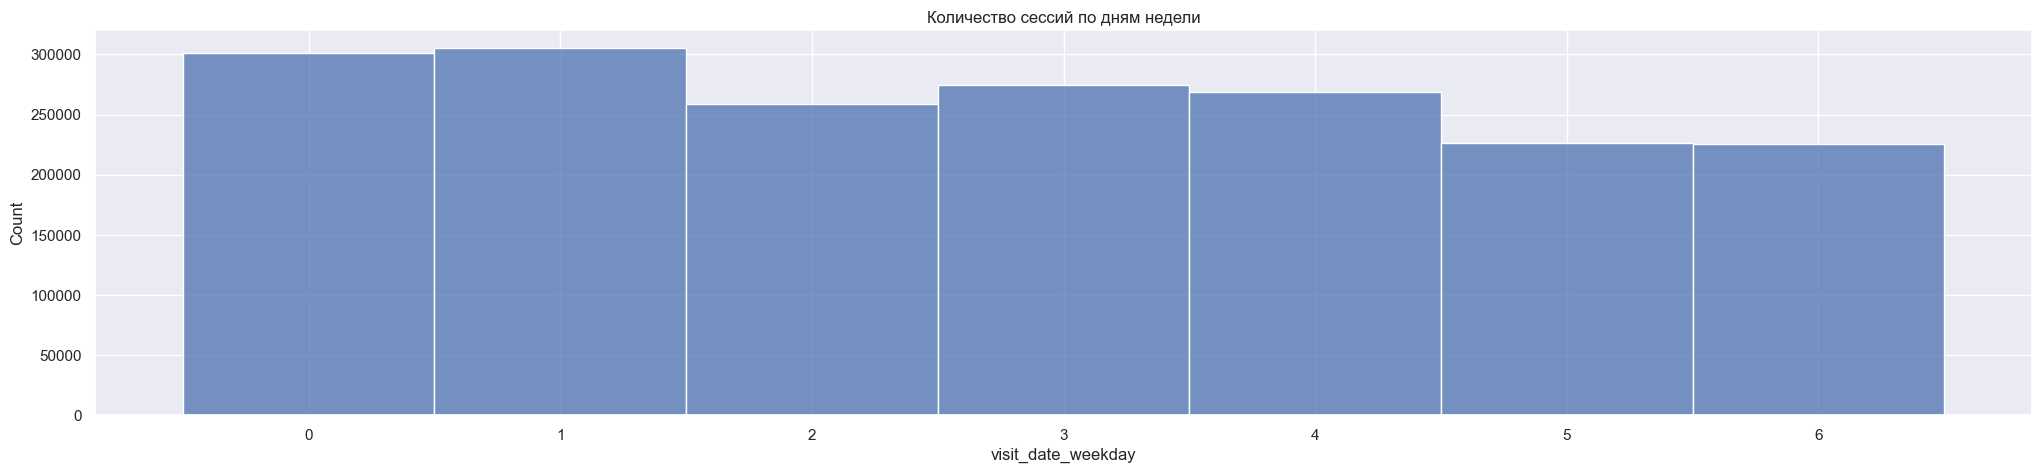

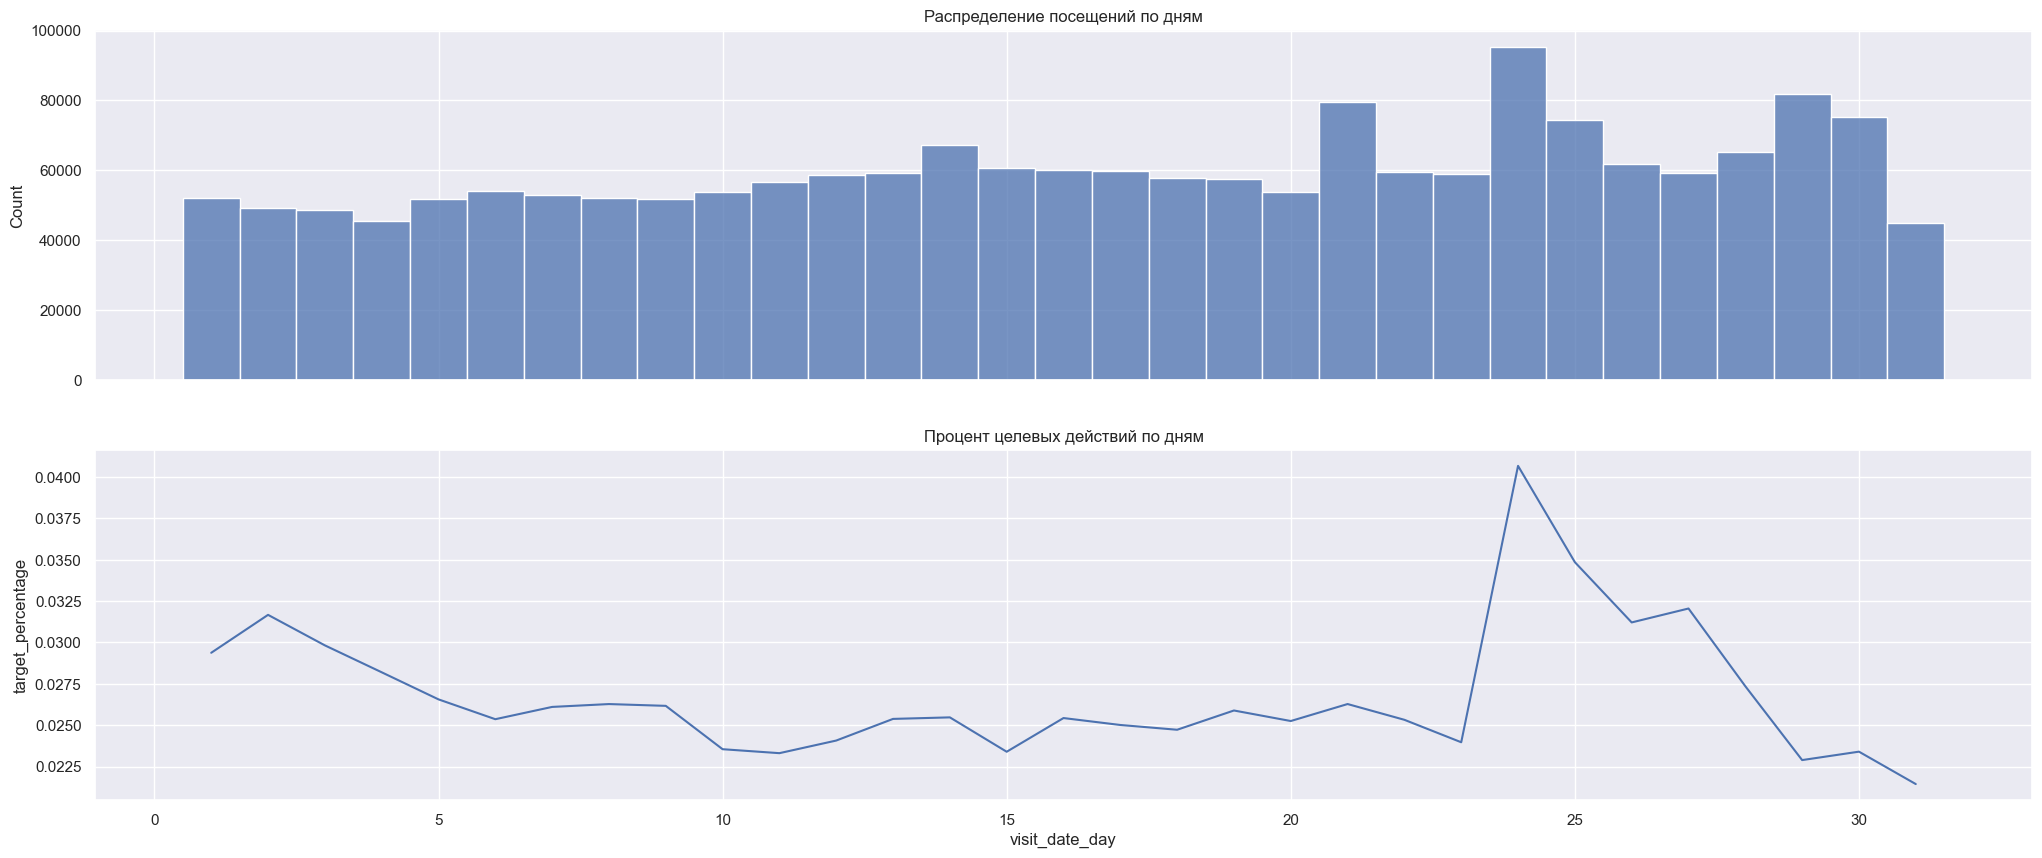

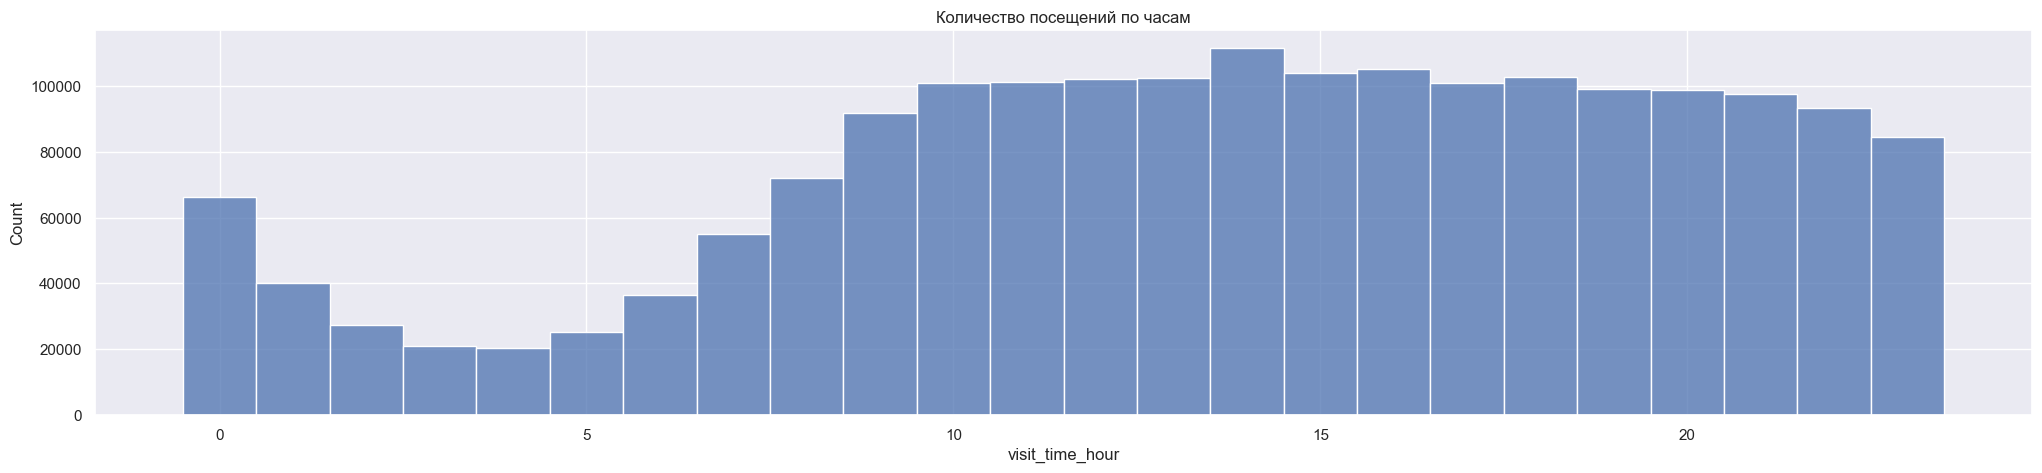

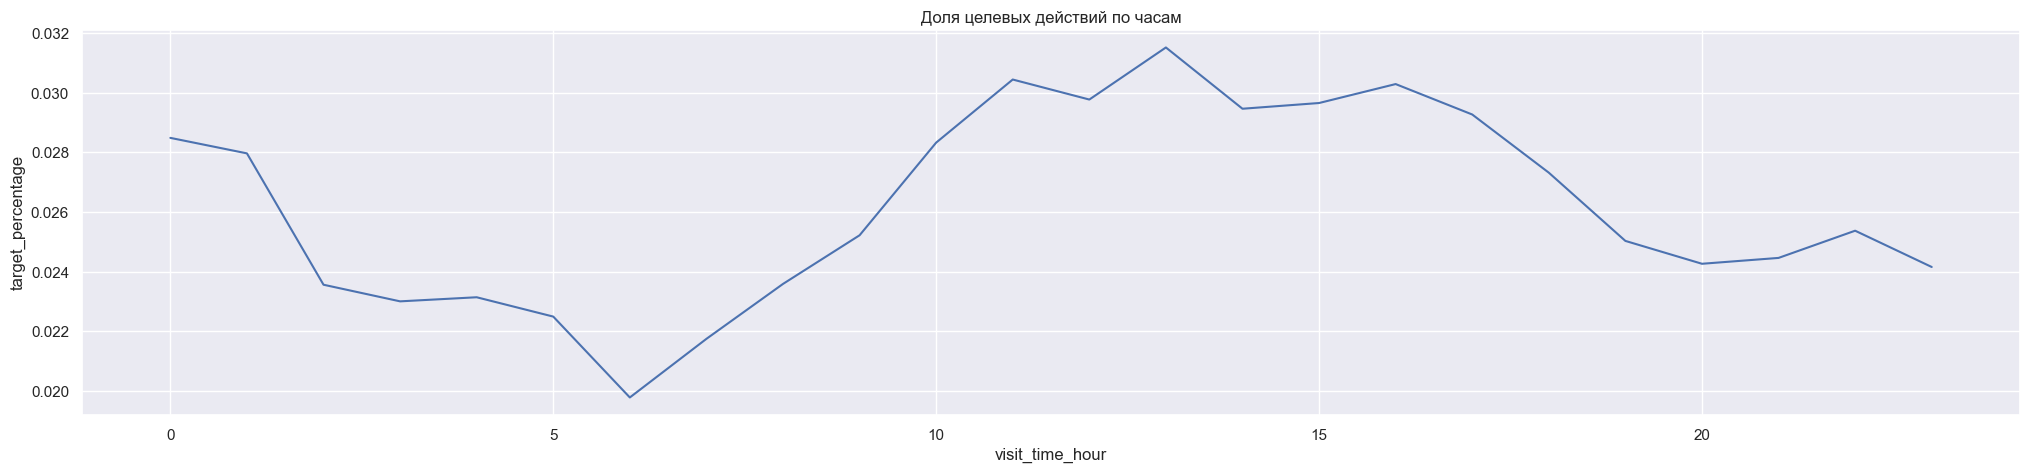

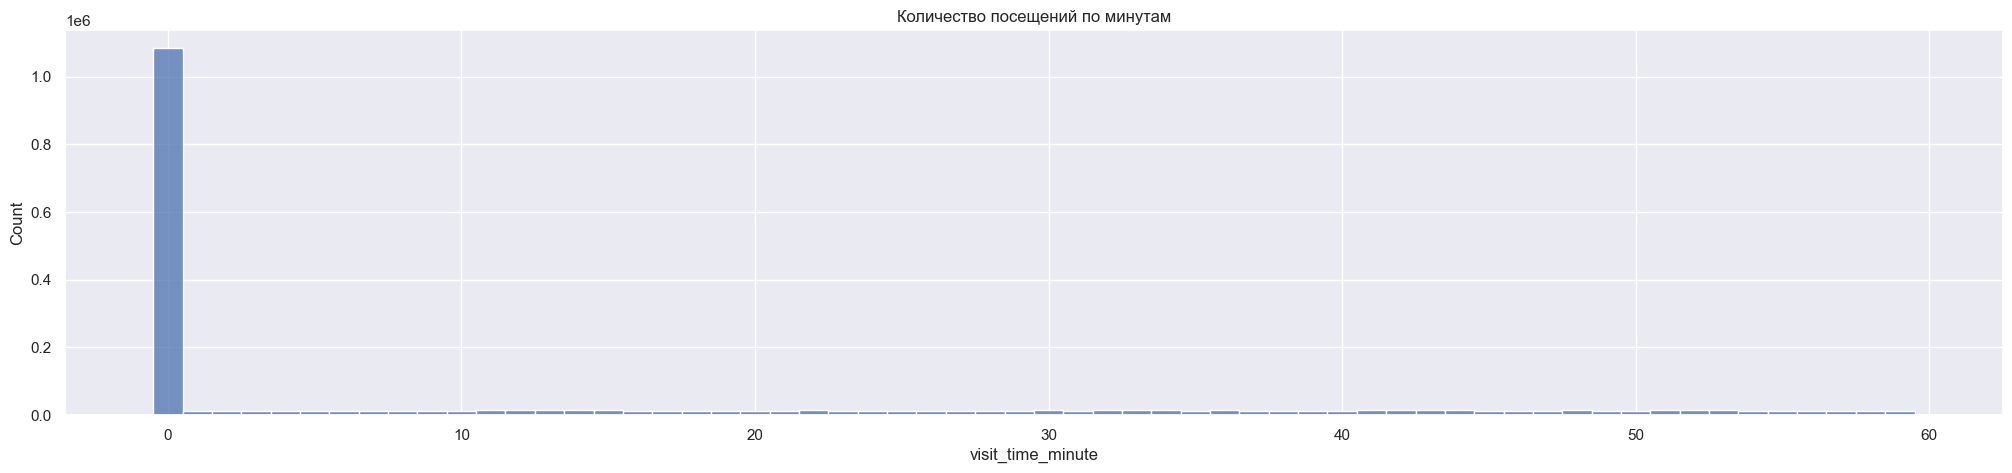

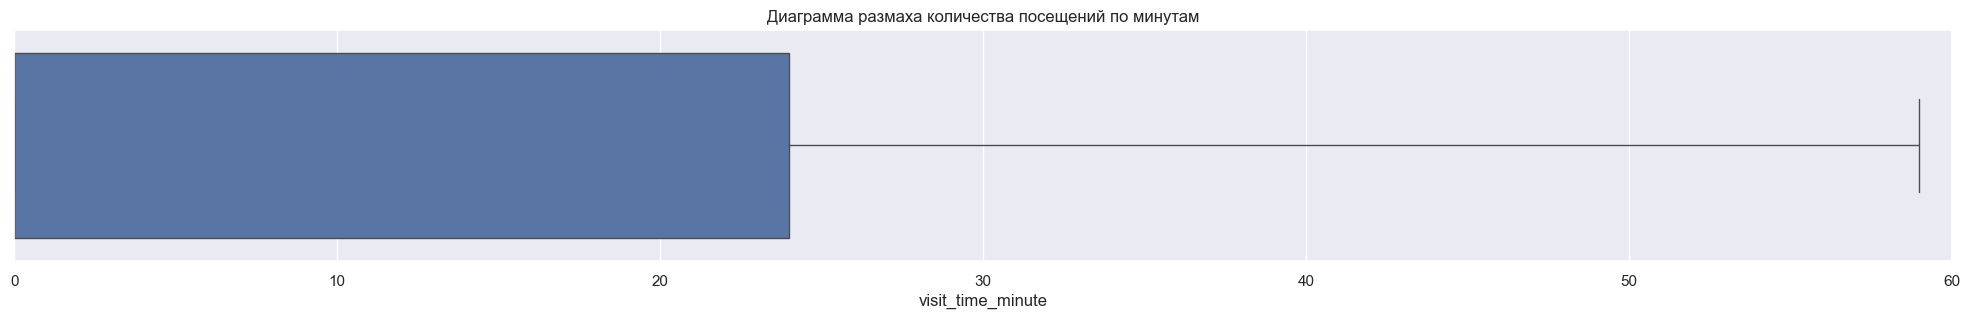

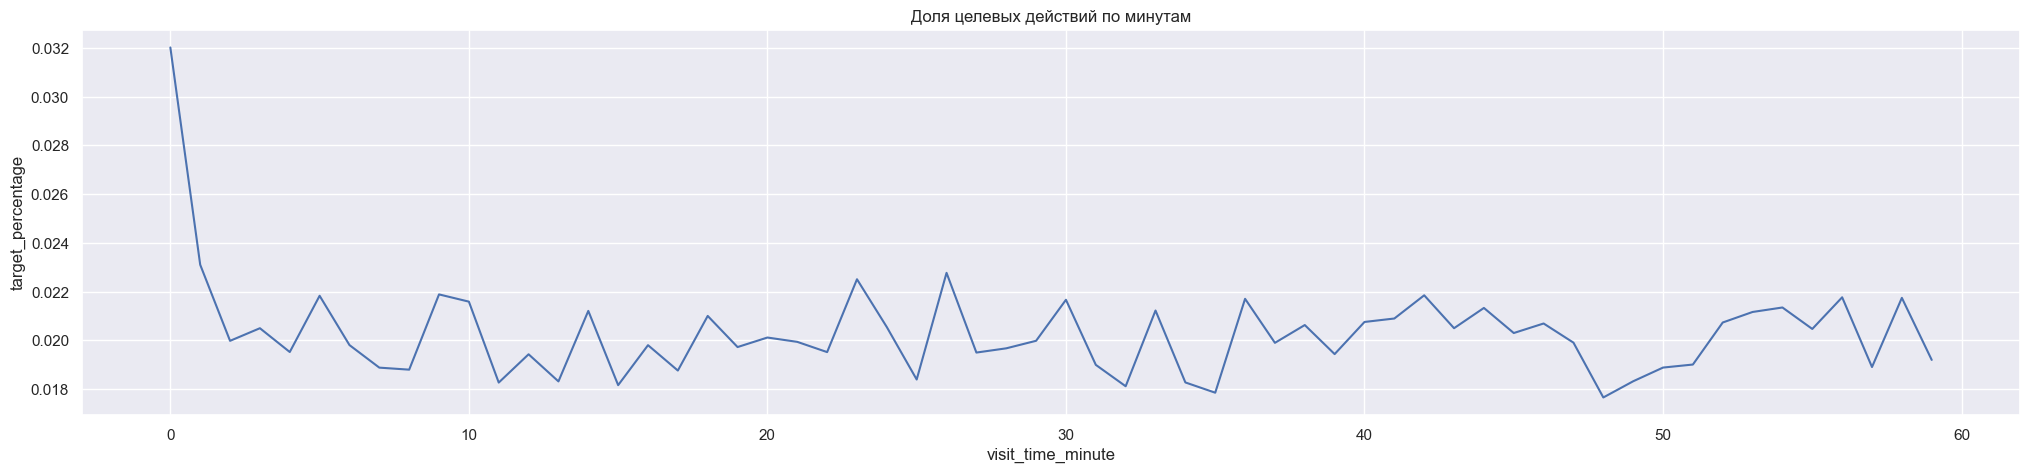

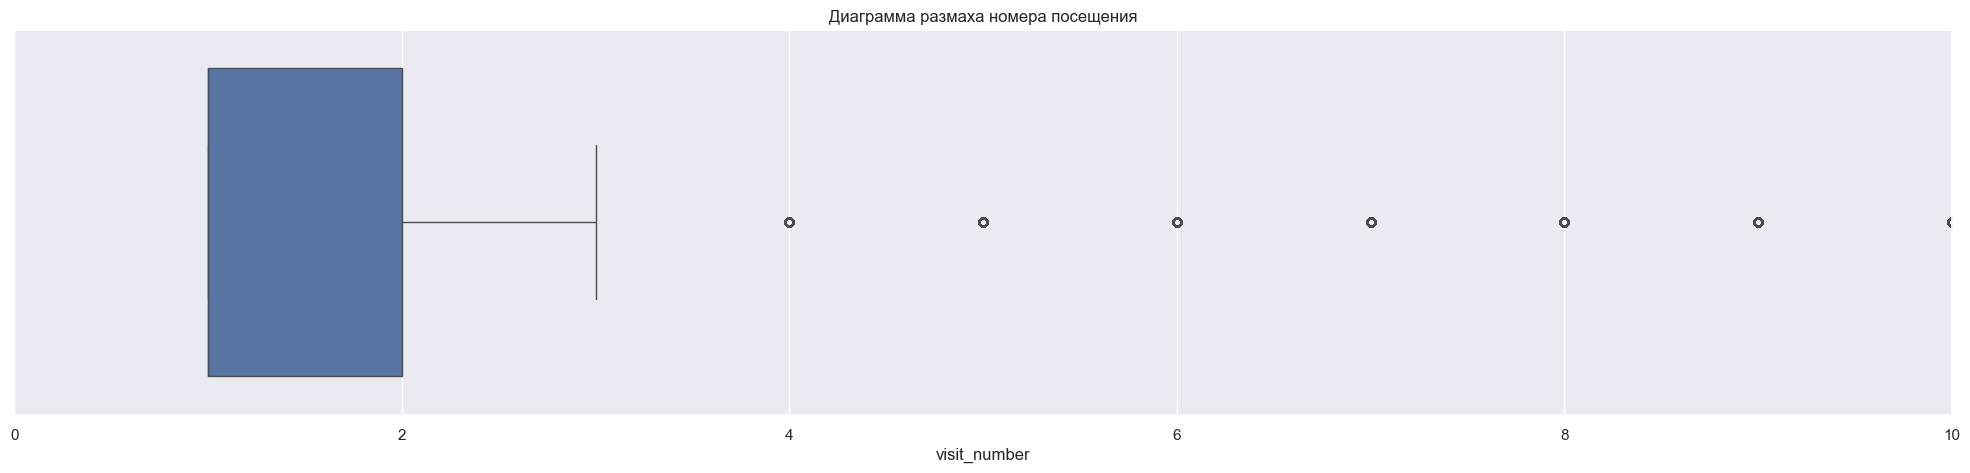

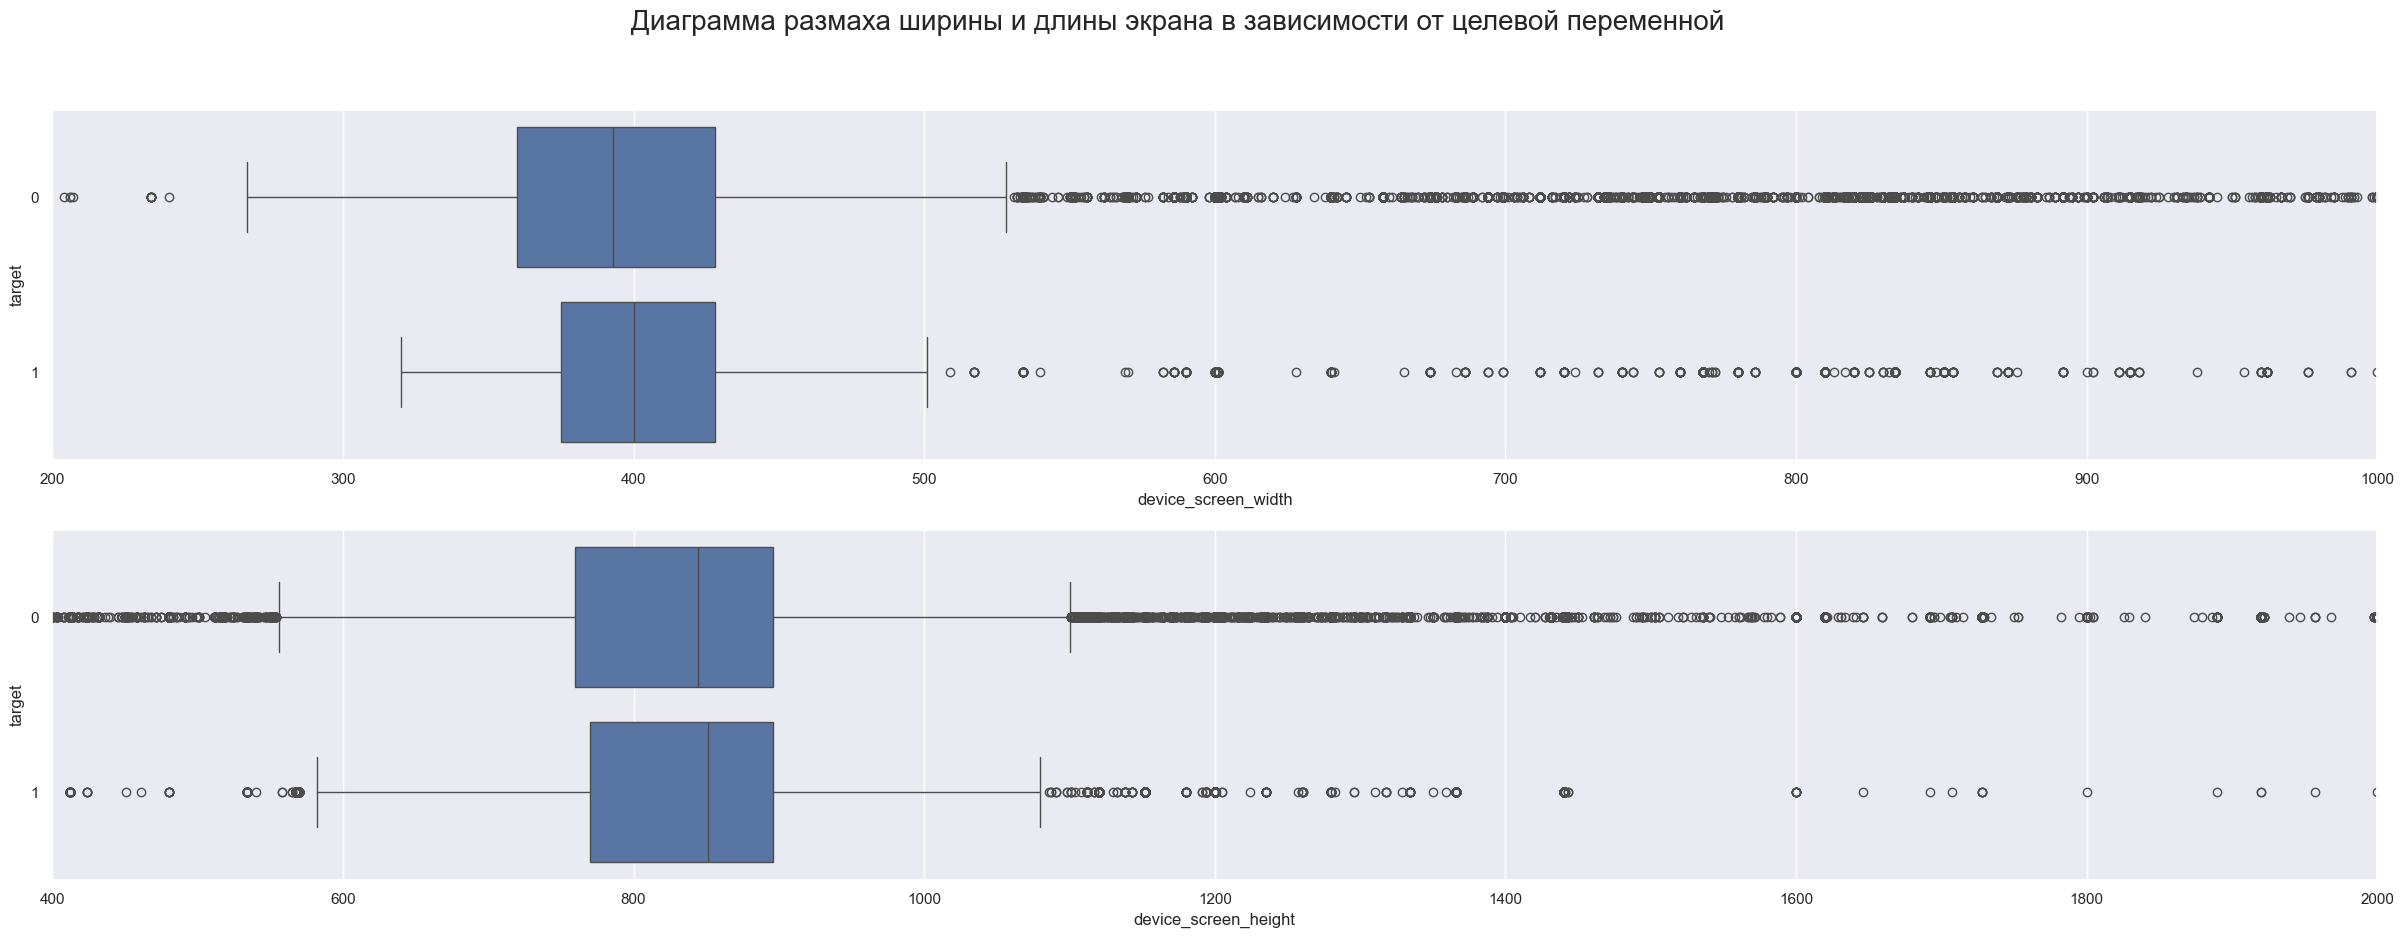

In [377]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 10))

sns.boxplot(data=df_session, x='device_screen_width', 
            y='target', ax=ax1, orient='h')
sns.boxplot(data=df_session, x='device_screen_height', 
            y='target', ax=ax2, orient='h')

# ограничим показ выбросов
ax1.set_xlim(200, 1000)
ax2.set_xlim(400, 2000)

fig.suptitle(f'Диаграмма размаха ширины и длины экрана '
             f'в зависимости от целевой переменной', fontsize='20')
plt.show()

Создадим дополнительные признаки - площадь экрана `device_screen_area` и соотношение сторон `device_screen_ratio`.

In [379]:
df_session['device_screen_area'] = df_session['device_screen_width'] * df_session['device_screen_height']
df_session['device_screen_ratio'] = df_session['device_screen_width'] / df_session['device_screen_height']

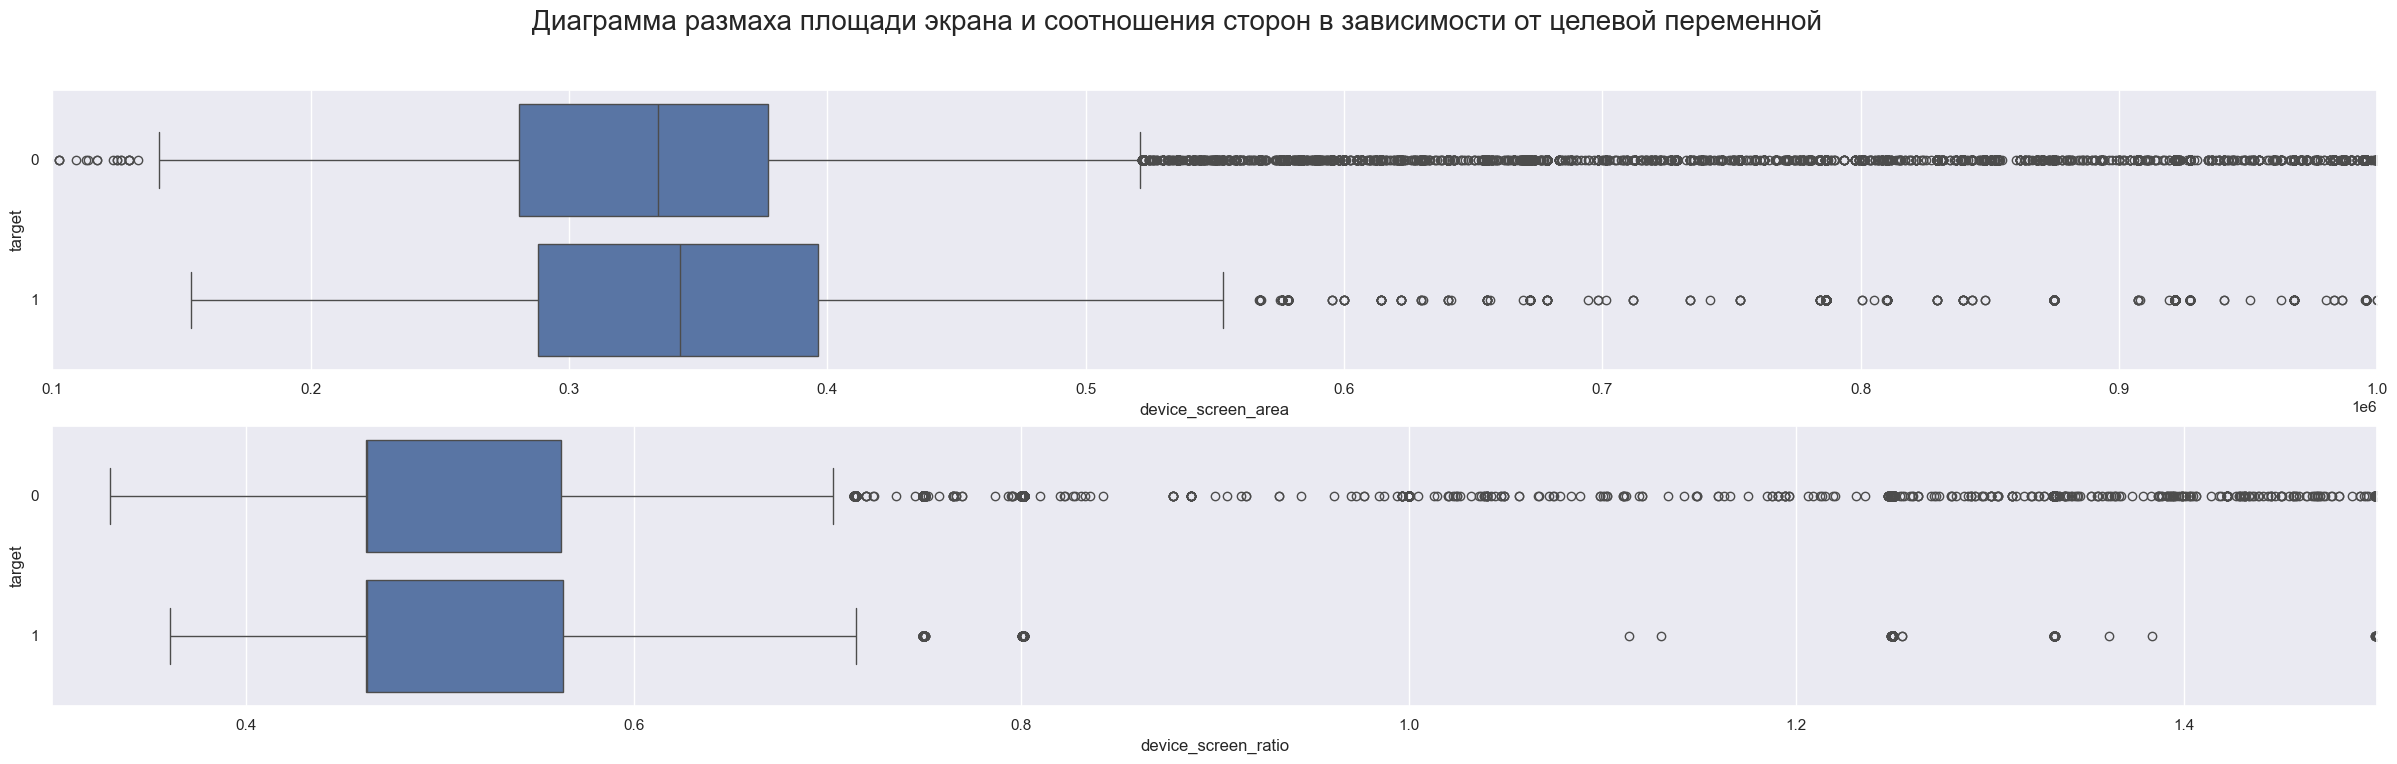

In [380]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 8))

sns.boxplot(data=df_session, x='device_screen_area', 
            y='target', ax=ax1, orient='h')
sns.boxplot(data=df_session, x='device_screen_ratio', 
            y='target', ax=ax2, orient='h')

# ограничим показ выбросов
ax1.set_xlim(100_000, 1_000_000)
ax2.set_xlim(0.3, 1.5)

fig.suptitle(f'Диаграмма размаха площади экрана и соотношения сторон '
             f'в зависимости от целевой переменной', fontsize='20')
plt.show()

### `device_browser` - браузер  

Пропущенных значений '(not set)' в колонке всего 17. Уникальных значений - 57, но большая часть встречается слишком редко.  

Больший процент целевых действий наблюдается с Яндекс Браузера.

In [382]:
missings = count_missings(df_session['device_browser'])
print(f'Количество пропущенных значений в `device_browser`: {missings}')

Количество пропущенных значений в `device_browser`: 17


In [383]:
n_unique = df_session['device_browser'].nunique()
print(f'Количество уникальных значений в `device_browser` = {n_unique}')

Количество уникальных значений в `device_browser` = 57


In [384]:
df_session['device_browser'].value_counts(dropna=False).head(15)

device_browser
Chrome                              1013436
Safari                               478562
YaBrowser                            133311
Safari (in-app)                       69912
Android Webview                       55369
Samsung Internet                      47309
Opera                                 26817
Firefox                               16588
Edge                                  16065
UC Browser                              871
Android Runtime                         392
Mozilla Compatible Agent                362
[FBAN                                   269
Instagram 208.0.0.32.135 Android        140
Instagram 209.0.0.21.119 Android        111
Name: count, dtype: int64

In [385]:
print('Процент целевых действий для самых популярных браузеров:')
df_session['device_browser_frequent'] = replace_rare(df_session['device_browser'], 
                                                   tolerance=0.01)
target_percentage(df_session, 'device_browser_frequent', index_name='Браузер')

Процент целевых действий для самых популярных браузеров:


,Количество объектов,Доля от общего числа,Процент целевых действий
Браузер,,,
rare_other,35326,1.90%,3.18%
YaBrowser,133311,7.17%,3.07%
Android Webview,55369,2.98%,2.81%
Safari,478562,25.73%,2.78%
Chrome,1013436,54.48%,2.68%
Samsung Internet,47309,2.54%,2.66%
Opera,26817,1.44%,2.09%
Safari (in-app),69912,3.76%,1.75%


### `geo_country` - страна  

Пропущенных значений в колонке мало ('(not set)' - 1146). И большая часть пользователей из России, что неудивительно, так как сервис работает только здесь.  

И, естественно, пользователи из России совершают больше целевых действий.  


In [387]:
missings = count_missings(df_session['geo_country'])
print(f'Количество пропущенных значений в `geo_country`: {missings}')

Количество пропущенных значений в `geo_country`: 1146


In [388]:
n_unique = df_session['geo_country'].nunique()
print(f'Количество уникальных значений в `geo_country` = {n_unique}')

Количество уникальных значений в `geo_country` = 166


In [389]:
df_session['geo_country'].value_counts(dropna=False).head(15)

geo_country
Russia            1800565
United States       11784
Ukraine              9012
Ireland              4034
Belarus              3636
Sweden               2694
Kazakhstan           2279
Germany              2232
Turkey               1953
Netherlands          1549
Uzbekistan           1523
United Kingdom       1462
(not set)            1146
Kyrgyzstan            974
Georgia               935
Name: count, dtype: int64

In [390]:
print('Процент целевых действий для стран с наибольшим посещением сайта:')
df_session['geo_country_frequent'] = replace_rare(df_session['geo_country'], 0.002)
target_percentage(df_session, 'geo_country_frequent', index_name='Страна')

Процент целевых действий для стран с наибольшим посещением сайта:


,Количество объектов,Доля от общего числа,Процент целевых действий
Страна,,,
Russia,1800565,96.80%,2.73%
rare_other,34647,1.86%,2.58%
Ukraine,9012,0.48%,2.21%
United States,11784,0.63%,0.54%
Ireland,4034,0.22%,0.02%


Посмотрим на распределение целевой переменной в России и за рубежом - `geo_country_is_russia`.

In [392]:
df_session['geo_country_is_russia'] = df_session['geo_country'] == 'Russia'

In [393]:
print('Процент целевых действий в России:')
target_percentage(df_session, 'geo_country_is_russia', index_name='Россия')

Процент целевых действий в России:


,Количество объектов,Доля от общего числа,Процент целевых действий
Россия,,,
True,1800565,96.80%,2.73%
False,59477,3.20%,1.95%


### `geo_city` - город  

Пропущенных значений 4%.  
Уникальных значений - 2548, но действительно важные - только 'Moscow' и 'Saint Petersburg'. Можно выделить отдельно города московской области и самые крупные города по населению.  

43% сессий из Москвы, 5% из Московской области, а остальные из других городов. В Москве и области целевых действий больше, но не слишком значительно.  

Больший процент целевых действий в Москве и в пределах 100 км от Москвы. Это и неудивительно, так как именно здесь сервис и работает по большей части.

In [395]:
missings = count_missings(df_session['geo_city']) /  len(df_session)
print(f'Количество пропущенных значений в `geo_city`: {missings:0.2%}')

Количество пропущенных значений в `geo_city`: 4.20%


In [396]:
n_unique = df_session['geo_city'].nunique()
print(f'Количество уникальных значений в `geo_city` = {n_unique}')

Количество уникальных значений в `geo_city` = 2548


In [397]:
df_session['geo_city'].value_counts(dropna=False).head(15)

geo_city
Moscow              805329
Saint Petersburg    296788
(not set)            78172
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Samara               24992
Nizhny Novgorod      22227
Ufa                  21679
Novosibirsk          21568
Krasnoyarsk          16346
Chelyabinsk          15951
Tula                 15814
Voronezh             13908
Rostov-on-Don        13886
Name: count, dtype: int64

In [398]:
print('Процент целевых действий для городов с наибольшим посещением сайта:')
df_session['geo_city_frequent'] = replace_rare(df_session['geo_city'], 0.01)
target_percentage(df_session, 'geo_city_frequent', index_name='Город')

Процент целевых действий для городов с наибольшим посещением сайта:


,Количество объектов,Доля от общего числа,Процент целевых действий
Город,,,
Kazan,29531,1.59%,3.86%
Krasnodar,32243,1.73%,3.35%
Ufa,21679,1.17%,2.95%
Moscow,805329,43.30%,2.93%
Samara,24992,1.34%,2.91%
rare_other,491725,26.44%,2.53%
Nizhny Novgorod,22227,1.19%,2.51%
Yekaterinburg,35788,1.92%,2.48%
Saint Petersburg,296788,15.96%,2.40%


Создадим новый признак, учитывающий города из Московской области - `geo_moscow_region`.

In [400]:
df_session['geo_moscow_region'] = df_session['geo_city'].copy()
df_session['geo_moscow_region'][df_session['geo_city'] != 'Moscow'] = 'other'
region_mask = df_session['geo_city'].isin(moscow_region_cities)
df_session['geo_moscow_region'][region_mask] = 'Moscow region'

In [401]:
print('Процент целевых действий в Московской области:')
target_percentage(df_session, 'geo_moscow_region', index_name='Москва или регион')

Процент целевых действий в Московской области:


,Количество объектов,Доля от общего числа,Процент целевых действий
Москва или регион,,,
Moscow,805329,43.30%,2.93%
Moscow region,101694,5.47%,2.87%
other,953019,51.24%,2.49%


Создадим новый признак для больших городов - `geo_city_is_big`.

In [403]:
df_session['geo_city_is_big'] = df_session['geo_city'].isin(big_cities)

In [404]:
print('Процент целевых действий для больших городов:')
target_percentage(df_session, 'geo_city_is_big', index_name='Большой город')

Процент целевых действий для больших городов:


,Количество объектов,Доля от общего числа,Процент целевых действий
Большой город,,,
True,1380287,74.21%,2.78%
False,479755,25.79%,2.49%


Построим признак - расстояние от Москвы `geo_city_distance_from_moscow`. Расстояния получены с помощью библиотеки `geopy` и сохранены для удобства в словарь в файле `additional_data.py`. Расстояния есть только для российских городов, для остальных расстояние -1.

In [406]:
df_session['geo_city_distance_from_moscow'] = df_session['geo_city'].apply(get_distance_from_moscow)

In [407]:
plt.figure(figsize=(25, 5))
positive_distances = df_session[df_session['geo_city_distance_from_moscow'] > 0]
sns.boxplot(data=positive_distances, x='geo_city_distance_from_moscow', 
            y='target', orient='h')
plt.title('Диаграмма размаха расстояния до Москвы');

Разобъём дистанцию на категории, чтобы оценить влияние расстояния на целевую переменную - `geo_city_distance_from_moscow_category`.

In [409]:
def get_distance_category(distance: float) -> str:
    """Возвращает категорию расстояния до Москвы."""

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

df_session['geo_city_distance_from_moscow_category'] = df_session['geo_city_distance_from_moscow'].apply(get_distance_category)

In [410]:
print('Распределение объектов по расстоянию до Москвы:')
target_percentage(df_session, 'geo_city_distance_from_moscow_category', 
                  index_name='Дистанция до Москвы')

Распределение объектов по расстоянию до Москвы:


,Количество объектов,Доля от общего числа,Процент целевых действий
Дистанция до Москвы,,,
moscow,805329,43.30%,2.93%
< 100 km,102673,5.52%,2.90%
1000-3000 km,229616,12.34%,2.77%
500-1000 km,421113,22.64%,2.54%
100-500 km,107529,5.78%,2.50%
>= 3000 km,61687,3.32%,2.21%
no distance,132095,7.10%,1.96%


## Взаимодействия признаков

### Корреляции

Из численных признаков действительно коррелируют между собой только те, которые образованы из `device_screen_resolution`.  

In [413]:
numerical_columns = [
    'visit_number', 'target', 'visit_date_weekday', 'visit_date_day', 
    'visit_time_hour', 'visit_time_minute', 'device_screen_width', 
    'device_screen_height', 'device_screen_area', 'device_screen_ratio', 
    'geo_city_distance_from_moscow']

plt.figure(figsize=(24,12))
sns.heatmap(df_session[numerical_columns].corr(), annot=True, fmt='0.2f', cmap= 'gnuplot')
plt.title('Корреляция численных признаков');

### Категориальные признаки

Процент целевых действий органического трафика снижается гораздо быстрее к концу недели, чем процент неорганического трафика.

Органический трафик чаще совершает целевые действия с компьютера, а неорганический - со смартфона.

Для реферального типа привлечения больше всего действий в первую минуту часа, возможно из-за недобросовестной накрутки реферальных действий.

In [415]:
def target_ratio(data: pd.Series) -> str:
    """Возвращает процент целевых действий."""
    return as_percent(data.sum() / data.count())

In [416]:
print('Целевые действия органического трафика по дням недели:')
df_session.pivot_table(
    index='visit_date_weekday', columns='utm_medium_is_organic', 
    values='target', aggfunc=[target_ratio, 'count'])

Целевые действия органического трафика по дням недели:


target_ratio          count        
utm_medium_is_organic        False  True    False   True 
visit_date_weekday                                       
0                            2.28%  4.70%  193010  107896
1                            2.23%  4.32%  215645   89485
2                            2.26%  4.22%  185490   73126
3                            2.16%  3.93%  200492   73970
4                            2.01%  3.83%  205818   63001
5                            2.20%  3.34%  174327   52070
6                            2.24%  3.10%  169601   56111

In [417]:
print('Целевые действия органического трафика по устройствам:')
df_session.pivot_table(
    index='utm_medium_is_organic', columns='device_category', 
    values='target', aggfunc=[target_ratio, 'count'])

Целевые действия органического трафика по устройствам:


target_ratio                 count                
device_category            desktop mobile tablet desktop   mobile tablet
utm_medium_is_organic                                                   
False                        1.70%  2.28%  1.82%  194791  1136846  12746
True                         4.76%  3.68%  3.42%  172072   338025   5562

In [418]:
print('Целевые действия по различным типам привлечения в первую минуту часа:')
df_session.pivot_table(
    index='utm_medium_frequent', columns='visit_time_minute_is_zero', 
    values='target', aggfunc=[target_ratio, 'count'])

Целевые действия по различным типам привлечения в первую минуту часа:


target_ratio          count        
visit_time_minute_is_zero        False  True    False   True 
utm_medium_frequent                                          
(none)                           2.23%  3.87%   67374  233201
banner                           2.16%  3.51%  315462  236810
cpc                              2.41%  2.08%  148645  286149
cpm                              0.96%  1.11%  113909  128174
rare_other                       1.79%  3.30%   95596   82672
referral                         2.59%  6.24%   35723  116327

#### 

## Выводы по анализу предоставленных данных

Сервис "СберАвтоподписка" - новый продукт, потому, клинты его тщательно изучают. Только 2.7% сессий завершилось целевым действием. 
Это необходимо будет учесть когда будем разбивать данные на тренировочную и тестовую выборку, а также при выборе метрик для оценки моделей.  

Наблюдения:

+ В дневное время и в первой половине недели больше всего производится целевых действий. 
+ Чем больше раз пользователь посещает сайт, тем скорее он совершит целевое действие.  
+ Пользователи с органического трафика чаще совершали целевые действия. 
+ В нулевую минуту каждого часа совершалось большое количество целевых действий, но это, скорее всего, связанно с тем, что запись данных проводится по определенному алгоритму.
+ Пользователи, пришедшие из социальных сетей реже совершают целевые действия.
+ С компьютера совершается больше целевых действий. Это ещё заметнее для органического трафика.
+ Большинство целевых действий совершается пользоваетелями из Москвы или Московской области.
+ Из численных признаков коррелируют между собой только производные от разрешения экрана.
+ Процент целевых действий органического трафика заметно снижается к концу недели, в отличие от неорганического трафика.

Не все признаки получится использовать напрямую: 
+ колонка `session_id` будет использоваться как индекс окончательного датасета, и по сути не будет участвовать в обучении; 
+ `client_id` неудобно использовать, поэтому этот признак будет просто удалён; 
+ `visit_date` и `visit_time` прямо использоваться не будут, но из них будут получены дополнительные признаки, такие как: час посещения, день недели, является ли день выходным и т.д.;
+ `device_screen_resolution` напрямую использовать не получится, но из него можно получить дополнительные признаки: ширина, высота, площадь и соотношение экрана; 
+ в `device_model` слишком много пропусков, использоваться не будет;
+ в численных колонках много выбросов, их нужно будет обработать; 
+ большинство категориальных переменных имеет очень большое количество уникальных значений с небольшим числом повторений, поэтому редкие значения будут заменены на 'rare_other' для снижения размера датасета после one-hot кодирования; 
+ дополнительно можно получить производные признаки, как-то: привлечённые из социальных сетей `utm_social_media_source`, органический трафик `utm_organic_medium`, нахождение города в Московской области `geo_moscow_region`, пользователь из крупного города `geo_big_city` и расстояние до Москвы `geo_city_distance_from_moscow`.